# Predict the Crude Oil production trend 

Predict the Crude Oil production's trend base on the previous year Crude Oil data.  
The objective of this challenge is to predict the probability of increase of Crude Oil production per quarter per country based on several indicators collected during the previous year.

## Organization
The file is organized as follows :
- Data loading and preprocessing
- NaN values overview
- Vizualization
- Modelization
- Prediction

## 0. Data loading and preprocessing

In [42]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import *
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score

import missingno as msno
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook

# Seed
seed = 7
np.random.seed(seed)
pd.set_option('display.max_columns', None)
%matplotlib inline

In [43]:
# Data loading
data_train = pd.read_csv('data/Train.csv', delimiter=";")
data_test = pd.read_csv('data/Test.csv', delimiter=";")
output_df =  pd.read_csv('data/challenge_output_data_training_file_predict_the_crude_oil_production_trend.csv', delimiter=";")

I regrouped the two dataframes for convenience, and renamed the last column.

In [44]:
data_train = pd.merge(data_train, output_df, on='ID')

In [45]:
data_train = data_train.rename(columns={"Target" : "y"})

In [46]:
print data_train.shape
data_train.head()

(10159, 124)


ID  month  country  1_diffClosing stocks(kmt)  1_diffExports(kmt)  \
0  ID00001      5       52                     0.0000            237.0000   
1  ID00002     12       69                    28.0000            -34.0000   
2  ID00003      5       74                     0.0000              0.0000   
3  ID00004     11       34                   175.3701             91.5209   
4  ID00005      7        2                  -550.0674            251.9568   

   1_diffImports(kmt)  1_diffRefinery intake(kmt)  1_diffWTI  \
0              0.0000                     33.0000      -5.62   
1             60.0000                      7.0000      -5.95   
2            -29.1227                    -85.5816      -5.62   
3              0.0000                    339.4347       7.66   
4              0.0000                    -49.5277     -12.07   

   1_diffSumClosing stocks(kmt)  1_diffSumExports(kmt)  1_diffSumImports(kmt)  \
0                    10426.2462             12135.1024             20527.7805   
1                      195.2005              7500.1033              6335.0098   
2                    10426.2462             12135.1024             20527.7805   
3                    -2247.4834             -6806.1222            -10986.0493   
4                    -2652.6804              2165.7119             -4491.3056   

   1_diffSumProduction(kmt)  1_diffSumRefinery intake(kmt)  \
0                32234.6302                     25998.8106   
1                12732.1449                      9538.8196   
2                32234.6302                     25998.8106   
3                -6674.2251                    -14749.4891   
4                 8211.1276                      5942.2535   

   2_diffClosing stocks(kmt)  2_diffExports(kmt)  2_diffImports(kmt)  \
0                     0.0000           -159.0000              0.0000   
1                   -70.0000             20.0000              0.0000   
2                     0.0000              0.0000            190.8165   
3                   245.7604            788.8290              0.0000   
4                    43.1848           -353.1714              0.0000   

   2_diffRefinery intake(kmt)  2_diffWTI  2_diffSumClosing stocks(kmt)  \
0                    -17.0000      -5.05                    -3509.9957   
1                     -6.0000       2.31                     1655.5214   
2                    195.2832      -5.05                    -3509.9957   
3                    -89.0982      12.52                     6531.7226   
4                    -80.0270       1.59                    -1421.2644   

   2_diffSumExports(kmt)  2_diffSumImports(kmt)  2_diffSumProduction(kmt)  \
0              1123.9965             -6034.0395                -2105.2971   
1             -3691.7079              -836.2419                -4159.0155   
2              1123.9965             -6034.0395                -2105.2971   
3             11104.3518              5399.6183                12744.7301   
4             -6194.2674              7706.7709               -10581.6649   

   2_diffSumRefinery intake(kmt)  3_diffClosing stocks(kmt)  \
0                     -7860.3692                     0.0000   
1                     -4154.0051                   -19.0000   
2                     -7860.3692                     0.0000   
3                      2258.5159                  -216.9582   
4                      2893.4431                   333.4683   

   3_diffExports(kmt)  3_diffImports(kmt)  3_diffRefinery intake(kmt)  \
0             66.0000              0.0000                     12.0000   
1            107.0000             50.0000                      1.0000   
2              0.0000            -10.3627                    -10.1840   
3            382.0996              0.0000                   -108.7483   
4            219.2983              0.0000                    155.3307   

   3_diffWTI  3_diffSumClosing stocks(kmt)  3_diffSumExports(kmt)  \
0       3.47                    -1389.7911              8409.3483   
1  

In [47]:
print data_test.shape
data_test.head()

(2000, 123)


ID  month  country  1_diffClosing stocks(kmt)  1_diffExports(kmt)  \
0  ID10160      8       70                    15.0000                 0.0   
1  ID10161      1       37                   -15.4795                 0.0   
2  ID10162      9        6                   -65.0000               155.0   
3  ID10163      7       22                   156.5714               173.0   
4  ID10164      4       46                   -44.0000               -44.0   

   1_diffImports(kmt)  1_diffRefinery intake(kmt)  1_diffWTI  \
0             31.0000                   -145.0000       2.67   
1             63.1507                     62.3288     -14.59   
2              0.0000                      7.0000      -7.84   
3              0.0000                    -78.7143       0.63   
4              0.0000                    244.0000       2.05   

   1_diffSumClosing stocks(kmt)  1_diffSumExports(kmt)  1_diffSumImports(kmt)  \
0                    -1781.9870             -8987.7760            -10788.9881   
1                    -2593.1638             -5059.3172             -5678.4743   
2                     -364.8415             10673.4778             12380.9353   
3                     5560.8222               910.3264              1711.2441   
4                     2117.1984            -12089.1886            -15761.2775   

   1_diffSumProduction(kmt)  1_diffSumRefinery intake(kmt)  \
0               -10152.2781                    -12700.4009   
1               -10378.0484                     -6675.1075   
2                10282.5840                     14038.1986   
3                 9408.0013                      3833.9495   
4               -28688.8971                    -28772.4931   

   2_diffClosing stocks(kmt)  2_diffExports(kmt)  2_diffImports(kmt)  \
0                   -13.0000              0.0000            275.0000   
1                    36.5754              0.0000             54.9315   
2                    -5.0000            -91.0000              0.0000   
3                   -95.5714             84.1429              0.0000   
4                     0.0000              0.0000              0.0000   

   2_diffRefinery intake(kmt)  2_diffWTI  2_diffSumClosing stocks(kmt)  \
0                    365.0000      -7.84                     -364.8415   
1                      2.8767     -12.49                     1686.0018   
2                    -24.0000      -0.37                    -2531.2443   
3                      1.5714      -0.77                      280.5374   
4                      0.0000      -2.12                     7381.9485   

   2_diffSumExports(kmt)  2_diffSumImports(kmt)  2_diffSumProduction(kmt)  \
0             10673.4778             12380.9353                10282.5840   
1              8250.0877             15593.7823                15907.2569   
2             -9624.2279              3226.0401                -1244.8432   
3             -2773.5920              -510.7432                -8975.0606   
4             12978.5545             16781.7339                31928.8902   

   2_diffSumRefinery intake(kmt)  3_diffClosing stocks(kmt)  \
0                     14038.1986                   -40.0000   
1                     18490.0113                    -2.1918   
2                      6642.0106                    47.0000   
3                     -2098.3683                  -223.8572   
4                     25846.4190                    21.0000   

   3_diffExports(kmt)  3_diffImports(kmt)  3_diffRefinery intake(kmt)  \
0              0.0000           -107.0000                    110.0000   
1              0.0000            -54.5205                    -15.7534   
2           -232.0000              0.0000                     -3.0000   
3            221.4286              0.0000                     29.4286   
4              0.0000              0.0000                     49.0000   

   3_diffWTI  3_diffSumClosing stocks(kmt)  3_diffSumExports(kmt)  \
0      -0.37                    -2531.2443             -9624.2279   
1  

I have tried to feed our classifier with a column standing for the oil intake of the country.

In [48]:
data_train["conso"] = pd.Series(data=- data_train["12_diffClosing stocks(kmt)"] \
                                - data_train["12_diffExports(kmt)"] \
                                + data_train["12_diffImports(kmt)"] \
                                + data_train["1_diffRefinery intake(kmt)"], name="conso")
data_test["conso"] = pd.Series(data=- data_test["12_diffClosing stocks(kmt)"] \
                                - data_test["12_diffExports(kmt)"] \
                                + data_test["12_diffImports(kmt)"] \
                                + data_test["1_diffRefinery intake(kmt)"], name="conso")

## Goal
The objective of this challenge is to predict the probability of increase of Crude Oil production per quarter per country based on several indicators collected during the previous year.

To this end, we have a dataset of 123 explaining features, with :
- 120 float64
- 3 int64
- 1 object (ID column)
- 35 % training records with y = 1

Therefore we are dealing with an imbalanced class problem, and will keep that in mind for the modelization part.

### Small basic statistics

In [92]:
print data_train["y"].value_counts() / len(data_train["y"])
print
print data_train.info()

0    0.654001
1    0.345999
Name: y, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10159 entries, 0 to 10158
Columns: 125 entries, ID to conso
dtypes: float64(121), int64(3), object(1)
memory usage: 9.8+ MB
None


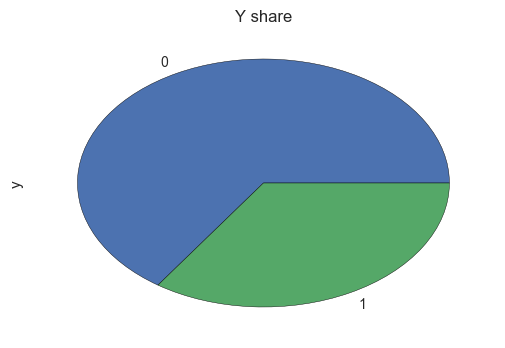

In [93]:
data_train["y"].value_counts().plot(kind="pie", title="Y share")

### Small global statistics

In [94]:
np.transpose(data_train.describe())

count        mean           std         min  \
month                           10159.0    6.473866      3.438871      1.0000   
country                         10159.0   38.442268     21.923267      1.0000   
1_diffClosing stocks(kmt)        9898.0    0.517624    761.965975 -39400.0000   
1_diffExports(kmt)              10159.0    3.772813    543.533615 -10200.0000   
1_diffImports(kmt)              10008.0    1.581989    677.256249 -22159.0000   
1_diffRefinery intake(kmt)      10159.0    3.531208   1874.477959 -73610.7409   
1_diffWTI                       10159.0    0.567494      6.699482    -32.6000   
1_diffSumClosing stocks(kmt)    10159.0   57.443267   6016.337184 -33236.7385   
1_diffSumExports(kmt)           10159.0  302.377589   7961.169490 -16196.6495   
1_diffSumImports(kmt)           10159.0  129.356949   9111.023583 -26272.2875   
1_diffSumProduction(kmt)        10159.0  387.809522  12819.753888 -28046.1357   
1_diffSumRefinery intake(kmt)   10159.0  305.419239  20404.435382 -71439.4140   
2_diffClosing stocks(kmt)        9902.0    0.742556    761.724351 -39400.0000   
2_diffExports(kmt)              10159.0    4.959824    543.609346 -10200.0000   
2_diffImports(kmt)              10011.0    2.777854    677.185134 -22159.0000   
2_diffRefinery intake(kmt)      10159.0    6.552034   1874.895261 -73610.7409   
2_diffWTI                       10159.0    0.543507      6.709918    -32.6000   
2_diffSumClosing stocks(kmt)    10159.0   81.652426   6022.238313 -33236.7385   
2_diffSumExports(kmt)           10159.0  371.192552   7964.623137 -16196.6495   
2_diffSumImports(kmt)           10159.0  212.352611   9104.624705 -26272.2875   
2_diffSumProduction(kmt)        10159.0  597.579487  12705.850266 -28046.1357   
2_diffSumRefinery intake(kmt)   10159.0  476.154170  20349.593763 -71439.4140   
3_diffClosing stocks(kmt)        9906.0    0.756207    760.428316 -39400.0000   
3_diffExports(kmt)              10159.0    3.266168    540.212842 -10200.0000   
3_diffImports(kmt)              10014.0    2.085293    675.497710 -22159.0000   
3_diffRefinery intake(kmt)      10159.0    4.444096   1873.822198 -73610.7409   
3_diffWTI                       10159.0    0.494593      6.706375    -32.6000   
3_diffSumClosing stocks(kmt)    10159.0   67.252350   6016.557513 -33236.7385   
3_diffSumExports(kmt)           10159.0  262.106381   7837.376082 -16196.6495   
3_diffSumImports(kmt)           10159.0  150.980411   9066.522039 -26272.2875   
...                                 ...         ...           ...         ...   
10_diffImports(kmt)             10035.0    1.666753    680.373585 -22159.0000   
10_diffRefinery intake(kmt)     10159.0    5.800392   1876.392698 -73610.7409   
10_diffWTI                      10159.0    0.517833      6.806354    -32.6000   
10_diffSumClosing stocks(kmt)   10159.0    4.234261   6039.745140 -33236.7385   
10_diffSumExports(kmt)          10159.0  240.206214   7901.891816 -16196.6495   
10_diffSumImports(kmt)          10159.0  125.844331   9148.828479 -26272.2875   
10_diffSumProduction(kmt)       10159.0  394.037004  12696.513769 -28046.1357   
10_diffSumRefinery intake(kmt)  10159.0  469.349083  20383.171695 -71439.4140   
11_diffClosing stocks(kmt)       9935.0   -0.098057    757.647774 -39400.0000   
11_diffExports(kmt)             10159.0    3.023665    541.345419 -10200.0000   
11_diffImports(kmt)             10038.0    1.906747    679.968729 -22159.0000   
11_diffRefinery intake(kmt)     10159.0    6.342198   1876.418096 -73610.7409   
11_diffWTI                      10159.0    0.529798      6.810870    -32.6000   
11_diffSumClosing stocks(kmt)   10159.0   19.068961   6039.385624 -33236.7385   
11_diffSumExports(kmt)          10159.0  208.394996   7882.452268 -16196.6495   
11_diffSumImports(kmt)          10159.0  137.001353   9157.467835 -26272.2875   
11_diffSumProduction(kmt)       10159.0  437.661116  12706.141011 -28046.1357   
11_diffSumRefinery intake(kmt)  10159.0  451.711159  20393.577376

In [95]:
print 'No. of duplicates in data_train = ', data_train.duplicated().sum()
print 'No. of duplicates in data_test = ', data_test.duplicated().sum()

No. of duplicates in data_train =  0
No. of duplicates in data_test =  0


## 1. NaN values overview
If we look into our train set, we see that it contains missing values (e.g. not given by the country).

In [96]:
print 'No. of columns with NaN values in data_train = ',(data_train.isnull().sum() > 0).sum()
print 'No. of columns with NaN values in data_test = ',(data_test.isnull().sum() > 0).sum()

No. of columns with NaN values in data_train =  25
No. of columns with NaN values in data_test =  0


Let us plot what % of values are NaN in each of the 24 columns.

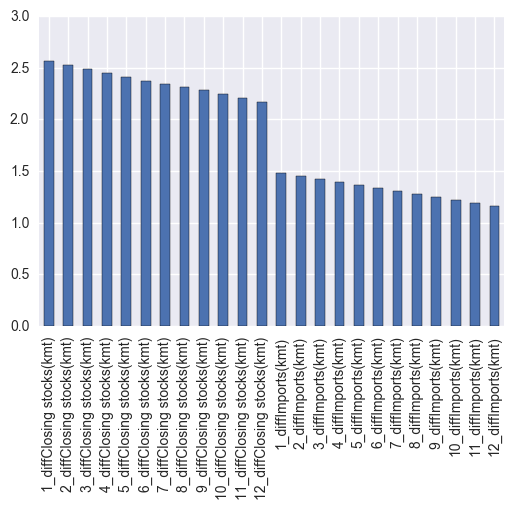

In [12]:
(100 * data_train.isnull().sum() / data_train.shape[0]).sort_values(ascending=False)[:24].plot(kind='bar');

Very small % : we could drop these value but we will see later that imputing them gives better results.

In [13]:
print data_train[data_train.isnull().any(axis=1)].shape
data_train[data_train.isnull().any(axis=1)]

(294, 124)


ID  month  country  1_diffClosing stocks(kmt)  1_diffExports(kmt)  \
73     ID00074     12       41                        NaN            241.3793   
87     ID00088      2       71                        NaN           3546.4719   
143    ID00144      3       41                        NaN            457.5173   
274    ID00275      9       42                        NaN            192.6121   
303    ID00304      5       42                        NaN            466.6227   
304    ID00305      9       42                        NaN            -77.1768   
355    ID00356     10       42                        NaN             -4.0897   
390    ID00391      6       42                        NaN            -27.7044   
404    ID00405     10       71                        NaN            138.7572   
453    ID00454      7       71                        NaN           -651.5272   
466    ID00467      5       42                        NaN            660.9498   
513    ID00514      4       33                        0.0           -806.8027   
520    ID00521      4       42                        NaN           -437.9947   
529    ID00530      7       71                        NaN            440.6266   
557    ID00558      7       41                        NaN           -623.8620   
618    ID00619      3       42                        NaN             40.8971   
633    ID00634      5       33                        NaN             55.3741   
642    ID00643     11       42                        NaN            -93.2717   
655    ID00656     10       42                        NaN             61.3457   
669    ID00670      6       71                        NaN            -24.7499   
696    ID00697      1       42                        NaN           -275.0660   
709    ID00710      3       33                        0.0            -42.1769   
710    ID00711      9       41                        NaN           -111.5862   
723    ID00724      8       41                        NaN           -852.9655   
732    ID00733     11       42                        NaN            213.3245   
791    ID00792      3       41                        NaN           -709.7931   
802    ID00803      5       71                        NaN            291.7324   
908    ID00909      6       33                        0.0           -389.5238   
979    ID00980     11       33                        NaN            177.1429   
1005   ID01006     12       33                        0.0            334.1497   
...        ...    ...      ...                        ...                 ...   
9083   ID09084     12       42                        NaN            130.2111   
9106   ID09107      2       33                        0.0             34.0136   
9125   ID09126     11       71                        NaN           -342.4171   
9131   ID09132     12       33                        NaN            328.9796   
9144   ID09145      8       33                        NaN           -241.9048   
9158   ID09159     12       71                        NaN            246.5772   
9184   ID09185      2       71                        NaN            644.1548   
9203   ID09204      5       41                        NaN            631.5862   
9248   ID09249      1       42                        0.0           -148.6808   
9259   ID09260      2       71                        NaN             30.2791   
9299   ID09300      2       41                        NaN            596.4138   
9304   ID09305      9       71                        NaN           1065.6925   
9320   ID09321      1       71                        NaN             -7.5039   
9428   ID09429     11       42                        NaN             93.6675   
9474   ID09475      8       71                        NaN            837.1512   
9498   ID09499      1       33                        0.0           -384.0816   
9554   ID09555      2       41                        NaN           -271.0345   
9730   ID09731      2       41             

We have NaN values only for 4 countries : we can assume that oil data is badly reported for them (government issues, etc...).

In [14]:
data_train[data_train.isnull().any(axis=1)].country.value_counts()

71    84
42    84
41    84
33    42
Name: country, dtype: int64

We can use the `missingno` package to have visual insights on NaNs :

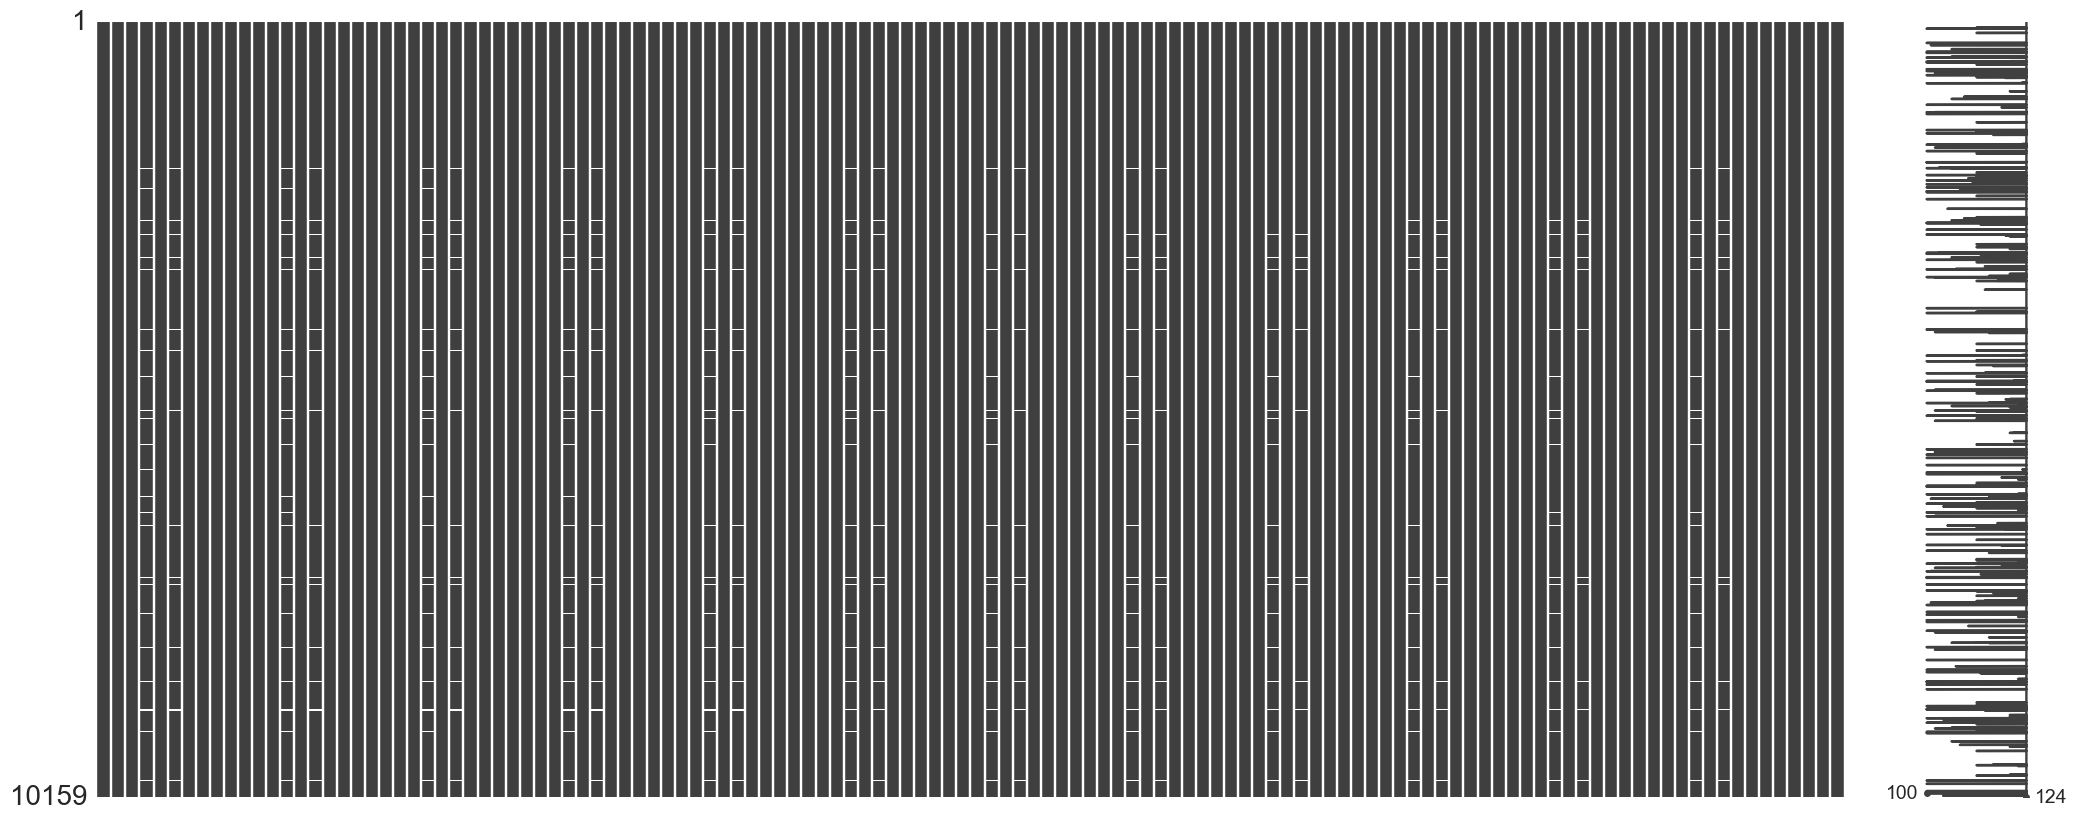

In [16]:
msno.matrix(data_train)

#### Nullity correlations
Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).  
Entries marked < 1 or > -1 are have a correlation that is close to being exactingly negative or positive, but is still not quite perfectly so.  
This points to a small number of records in the dataset which are erroneous.  
  
For example, in this dataset the correlation between 3_diffImports(kmt) and 1_diffImports(kmt) is < 1, indicating that, contrary to our expectation, there are a few records which have one or the other, but not both.  
These cases will require special attention.  
  
Note that variables with a variance of zero (that is, variables which are always full or always empty) have no meaningful correlation and so are silently removed from the visualization.

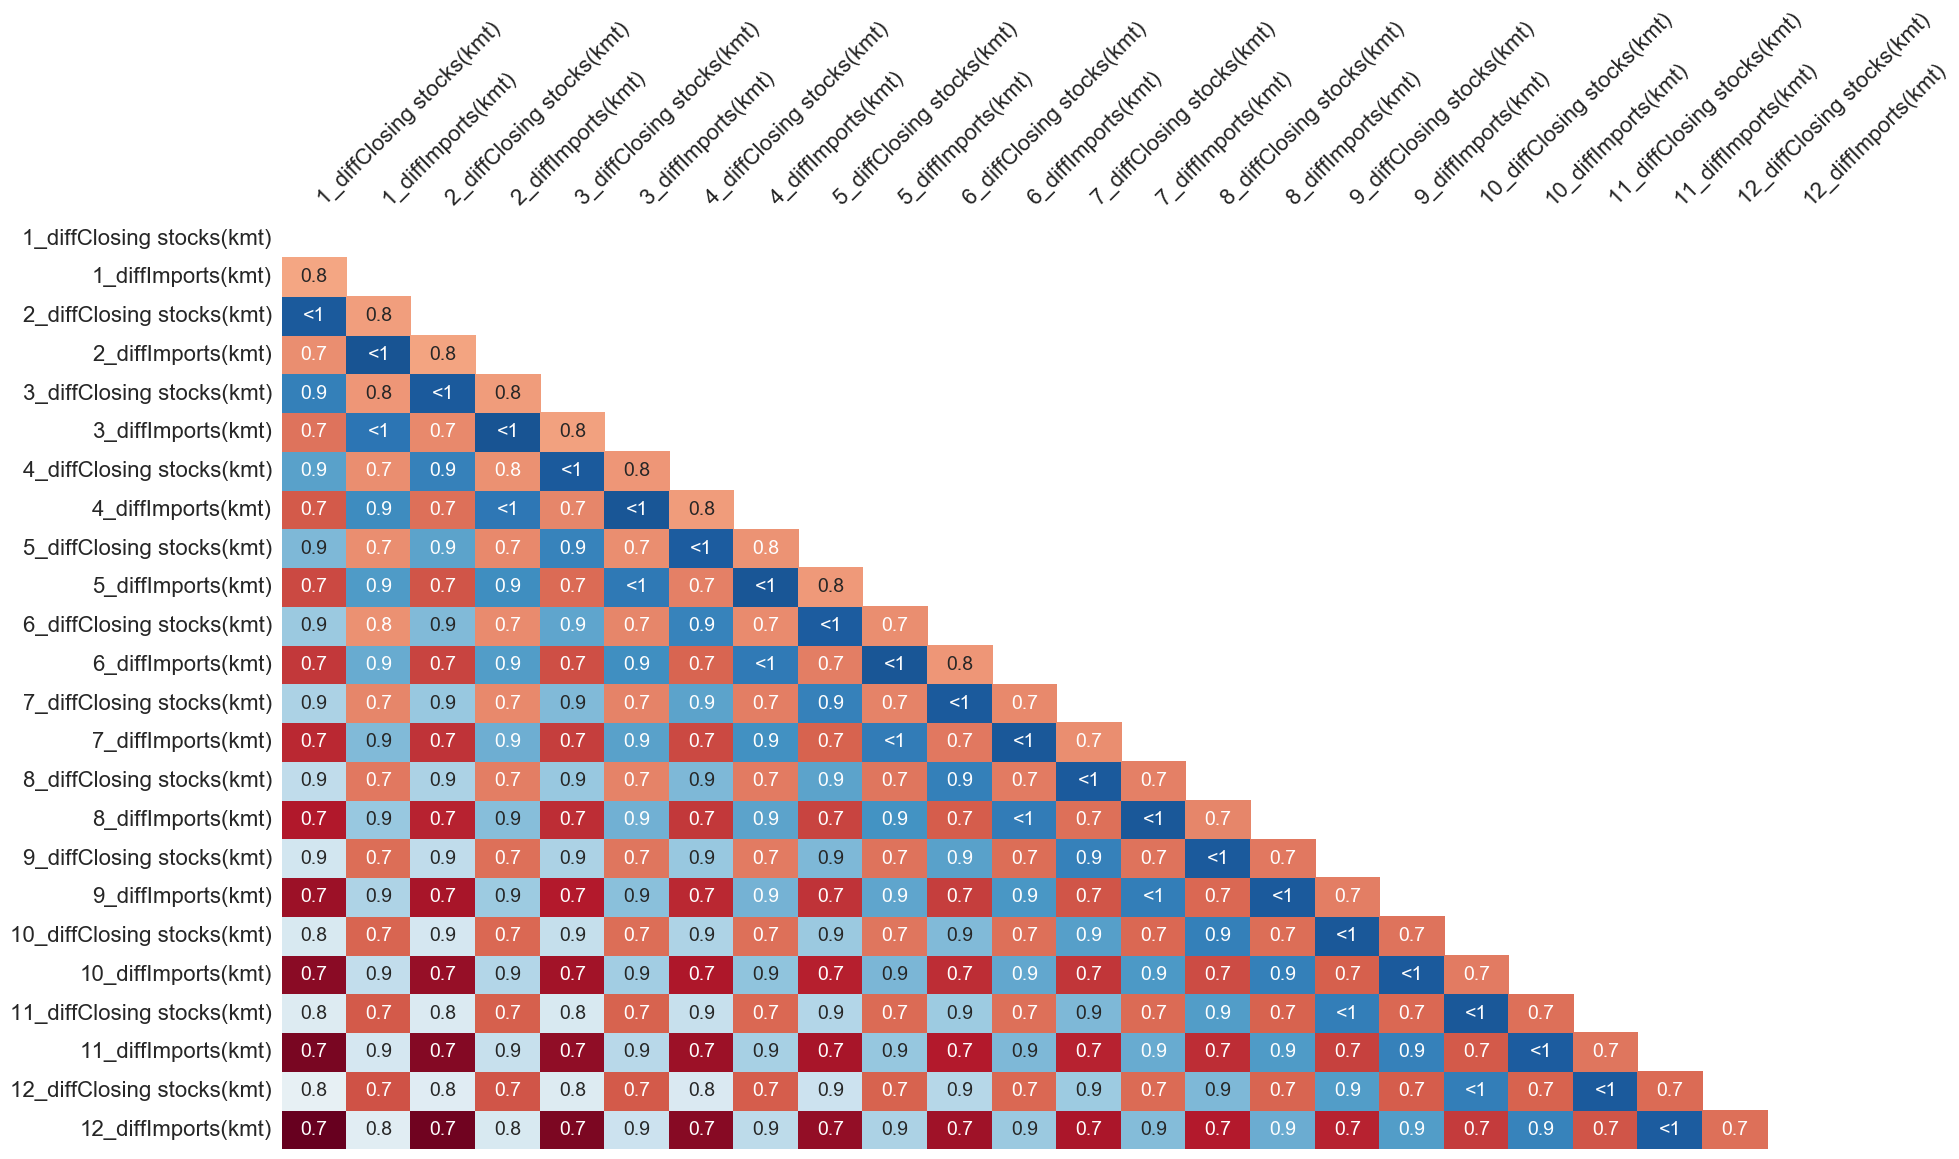

In [18]:
msno.heatmap(data_train)

Overall, data complenteness relations ships are good > 0.7.  

## 2. Vizualization
### Histograms

CPU times: user 11.9 s, sys: 239 ms, total: 12.1 s
Wall time: 13 s


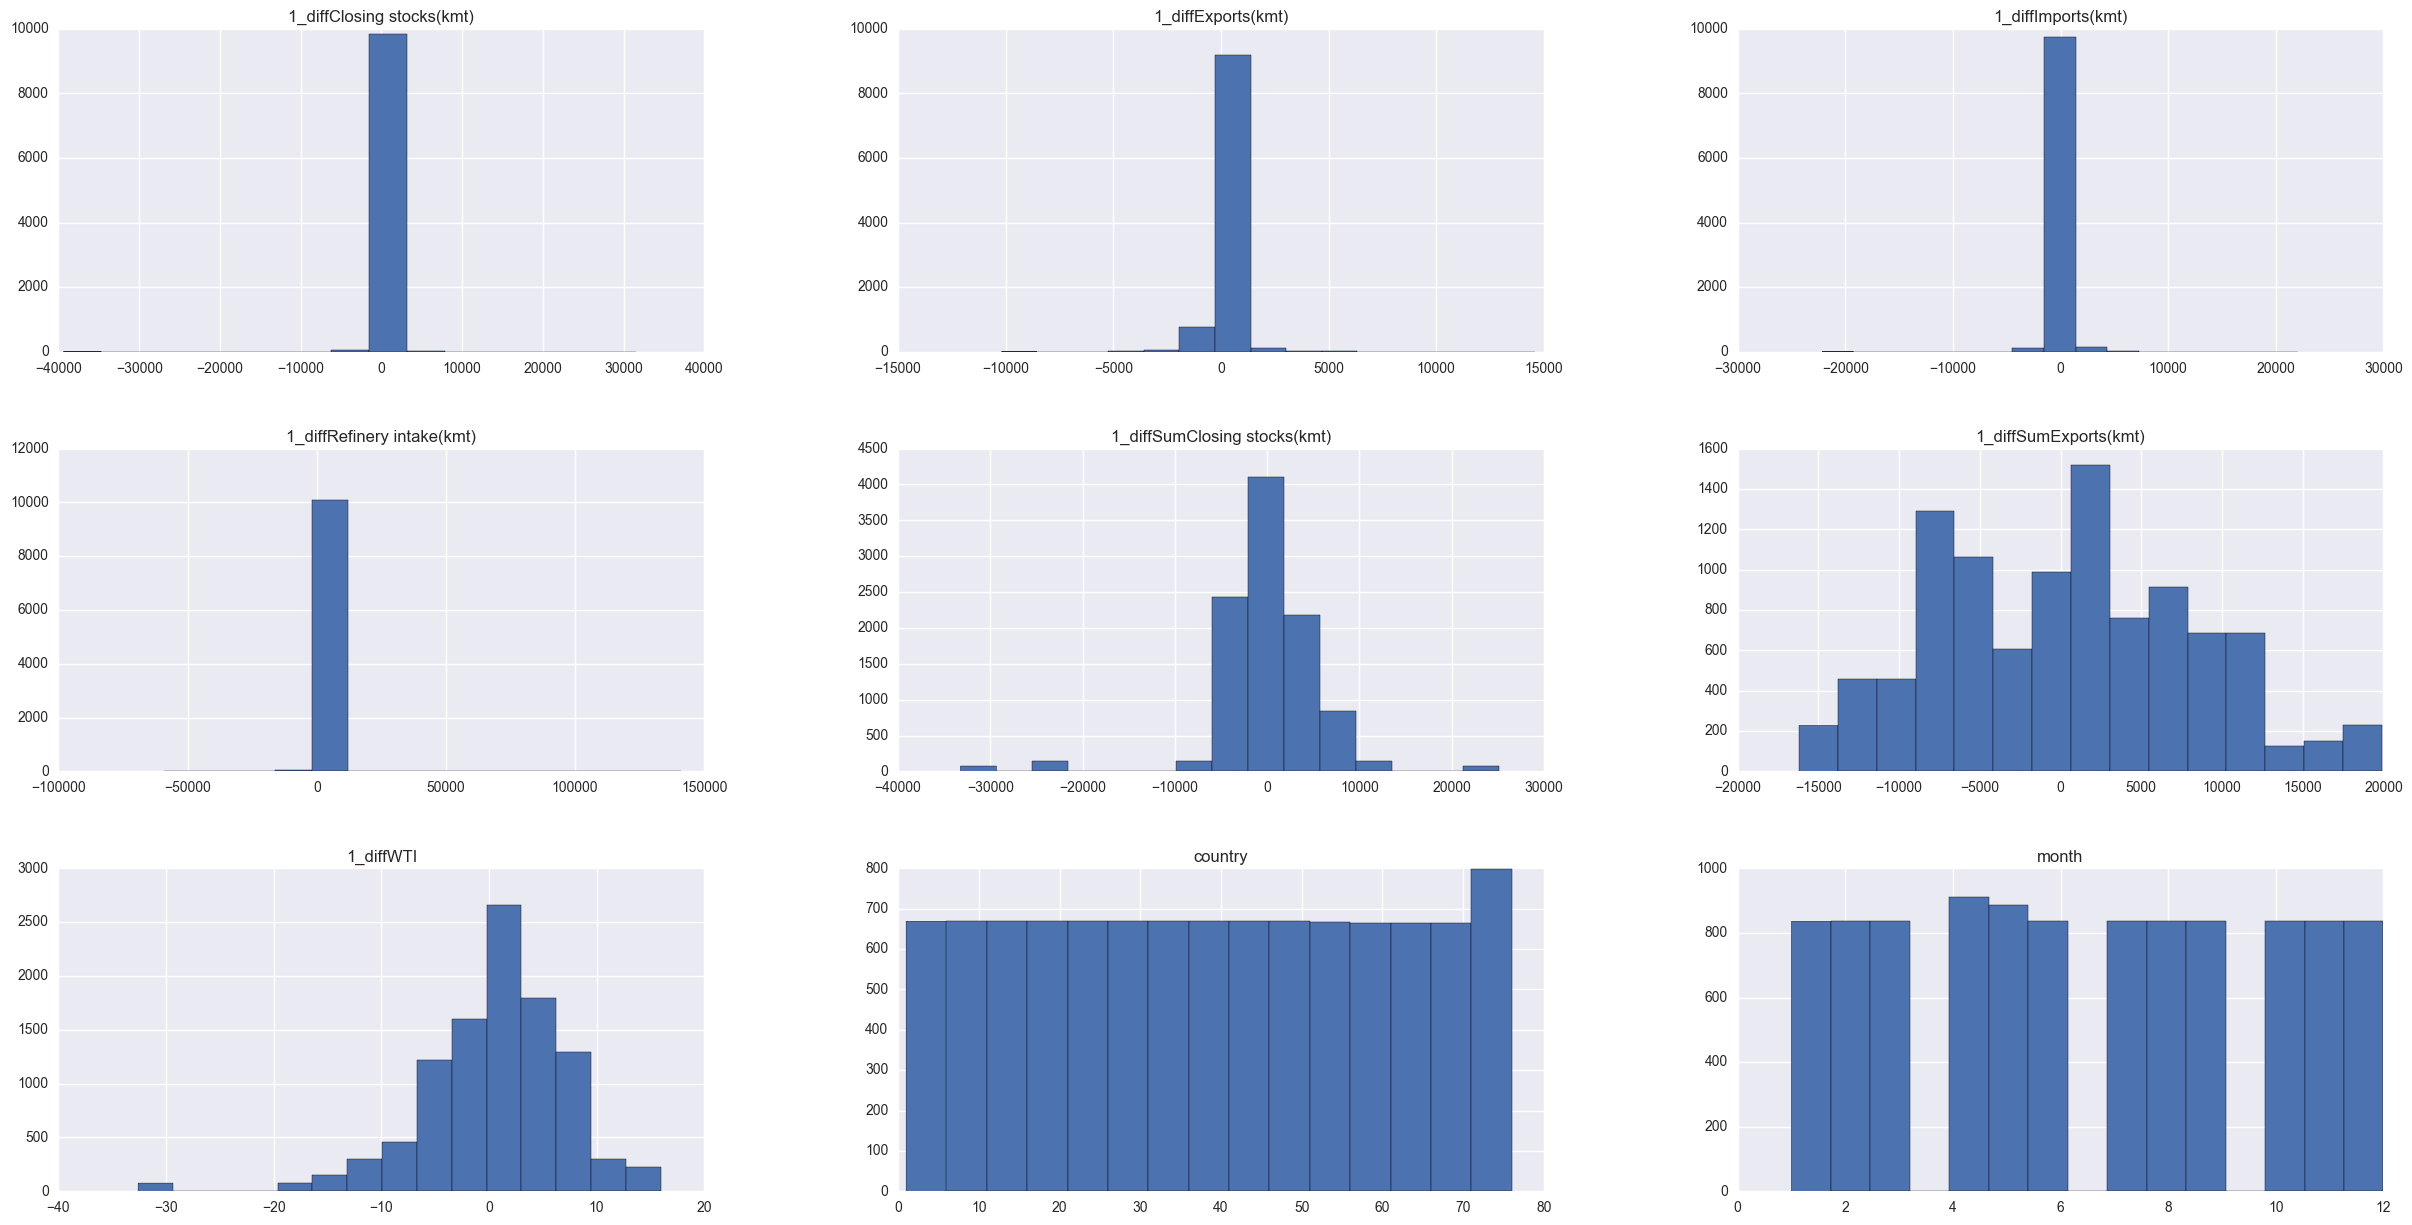

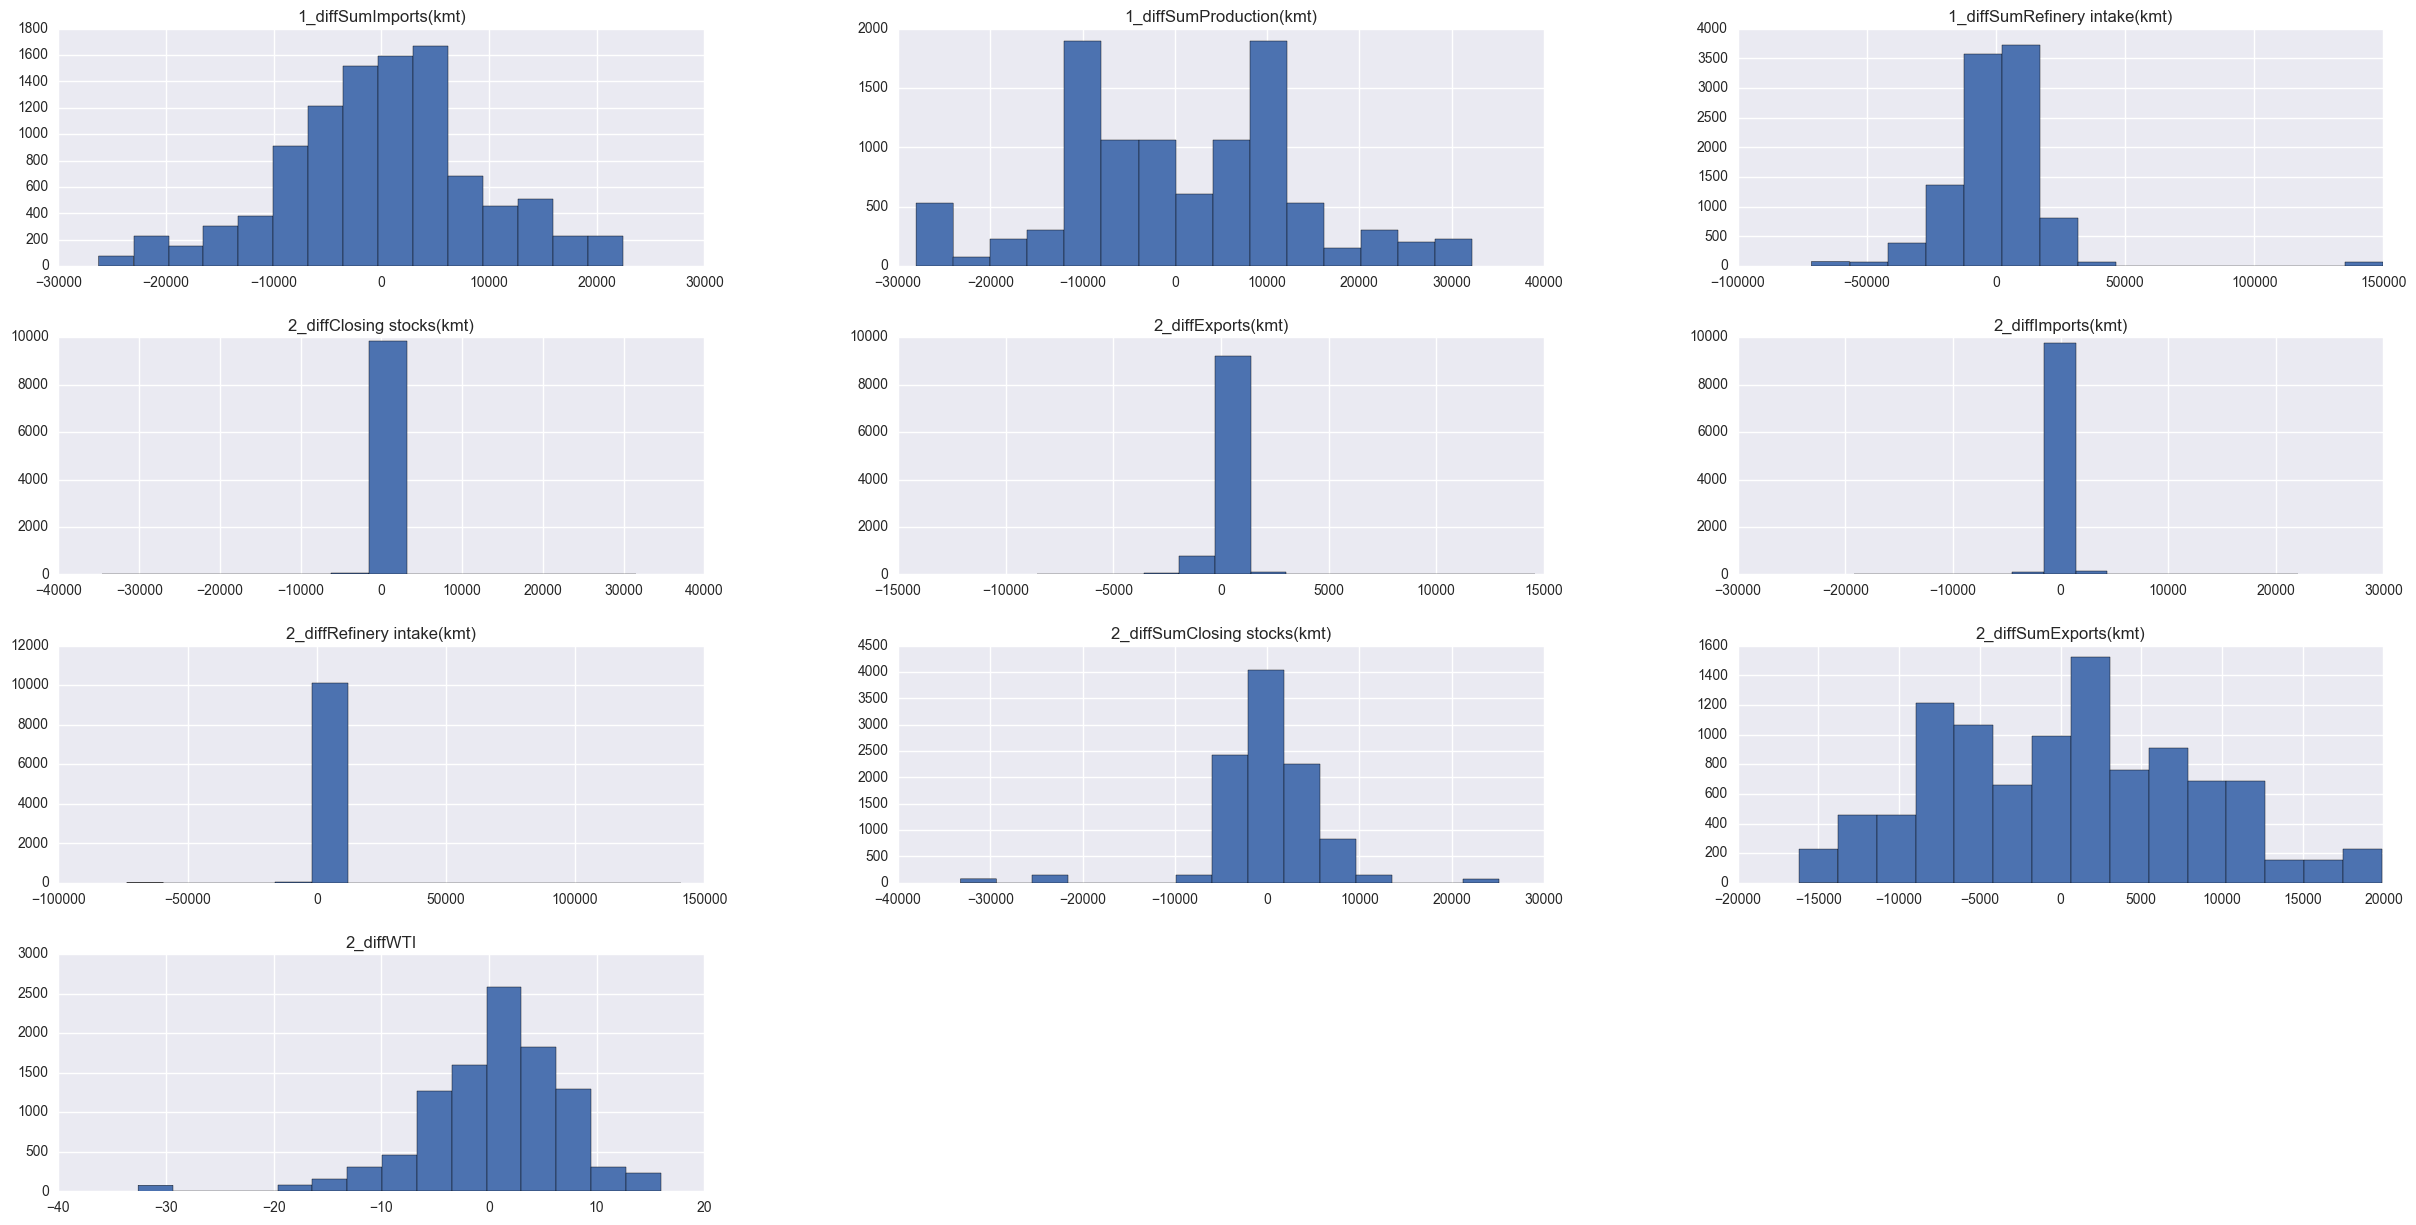

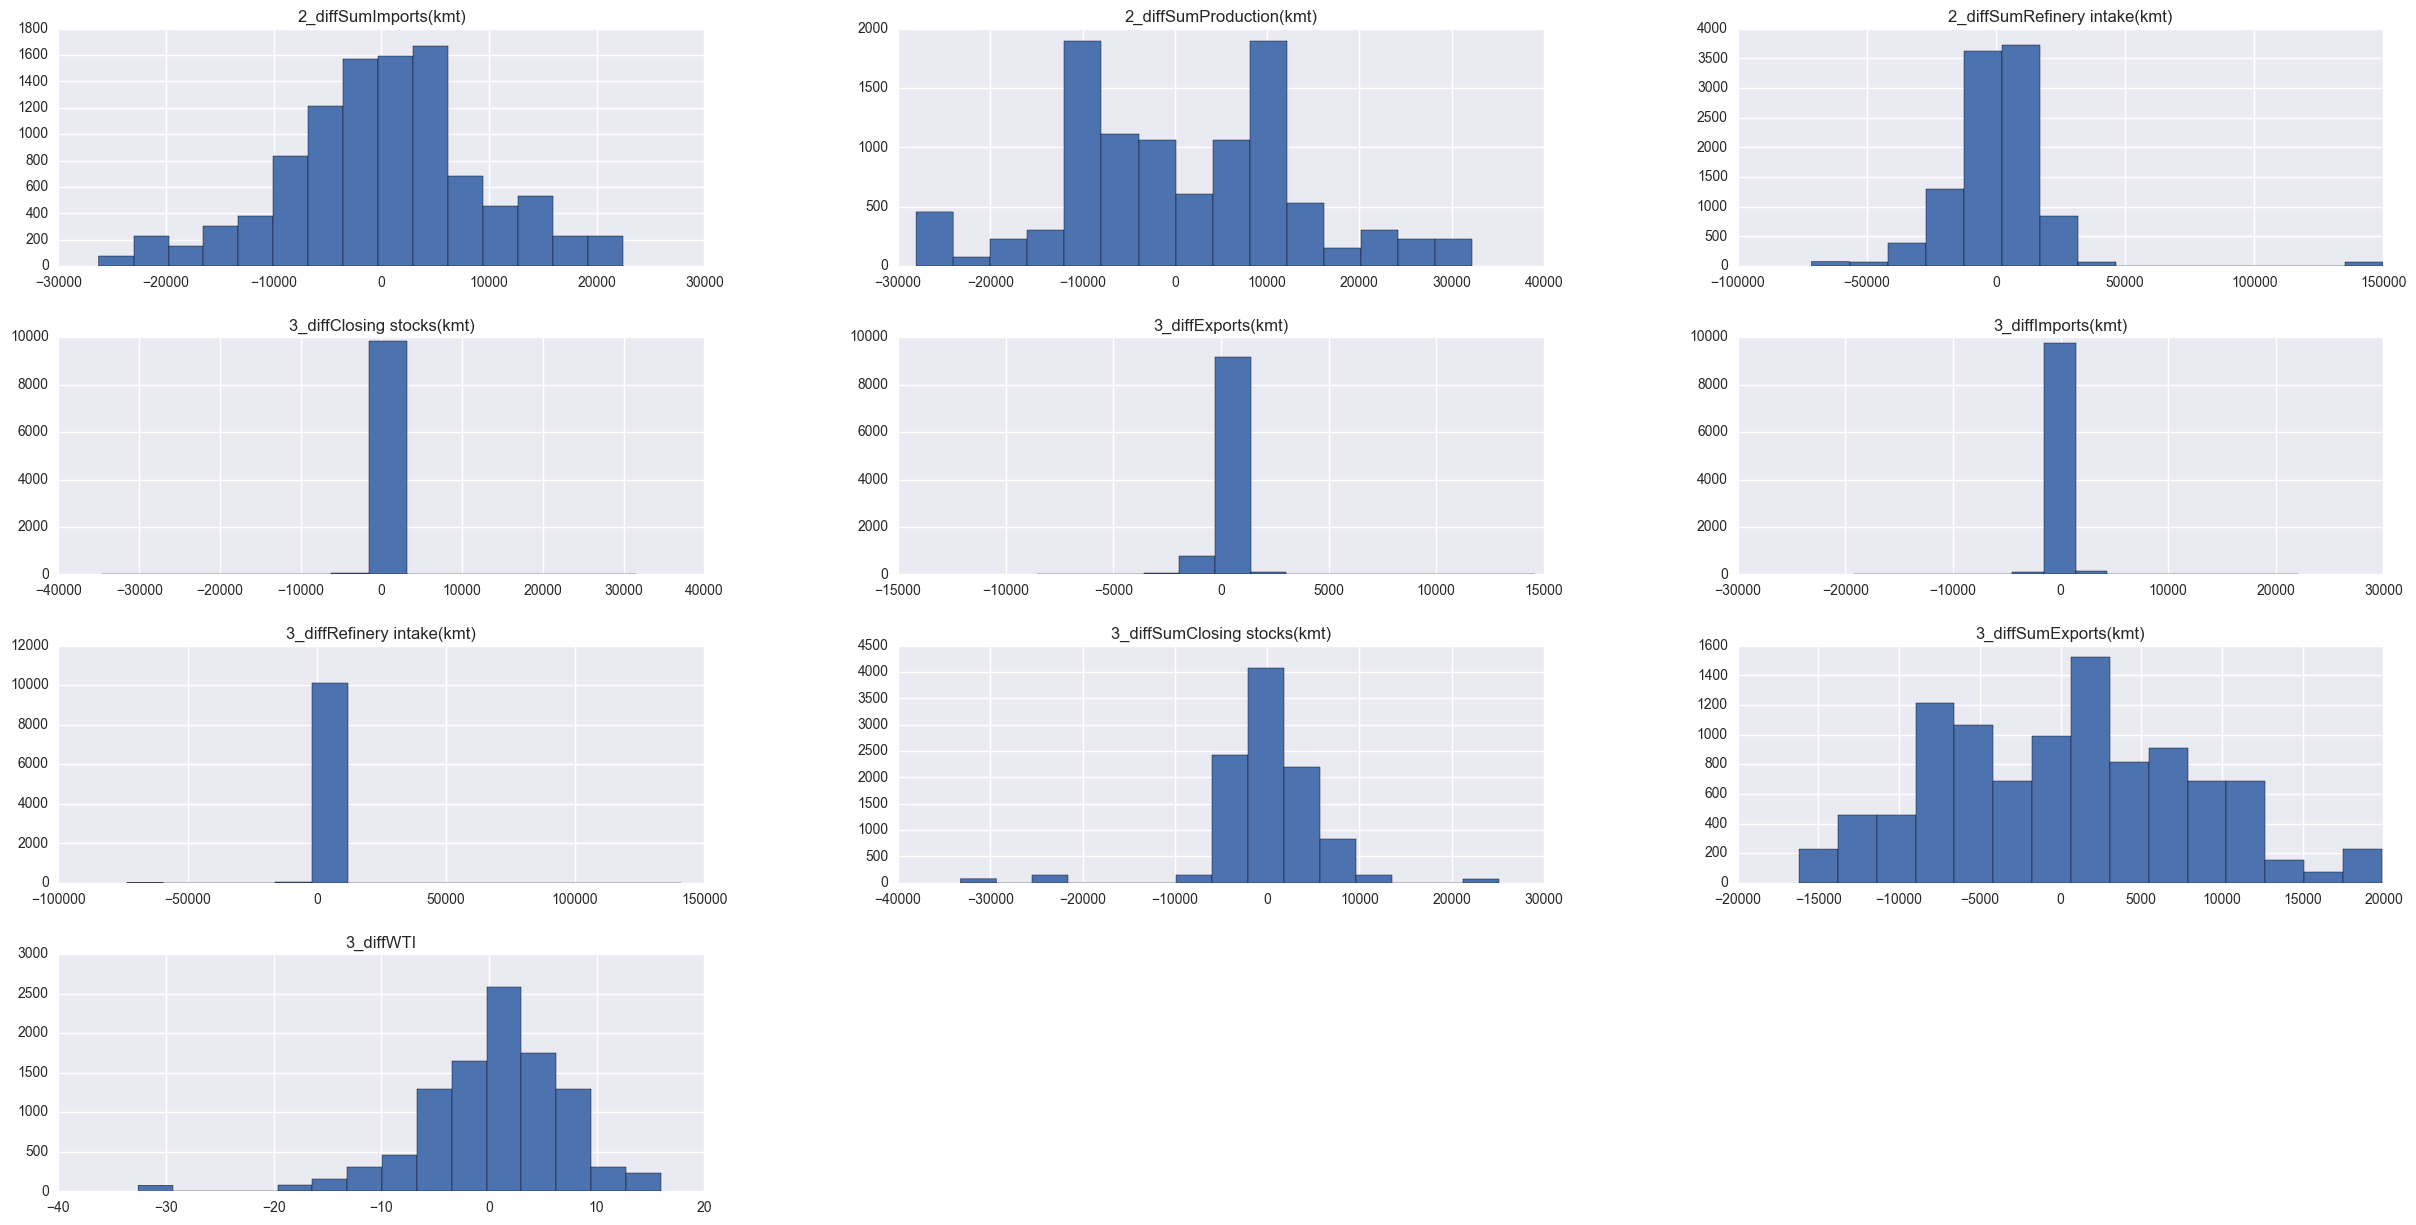

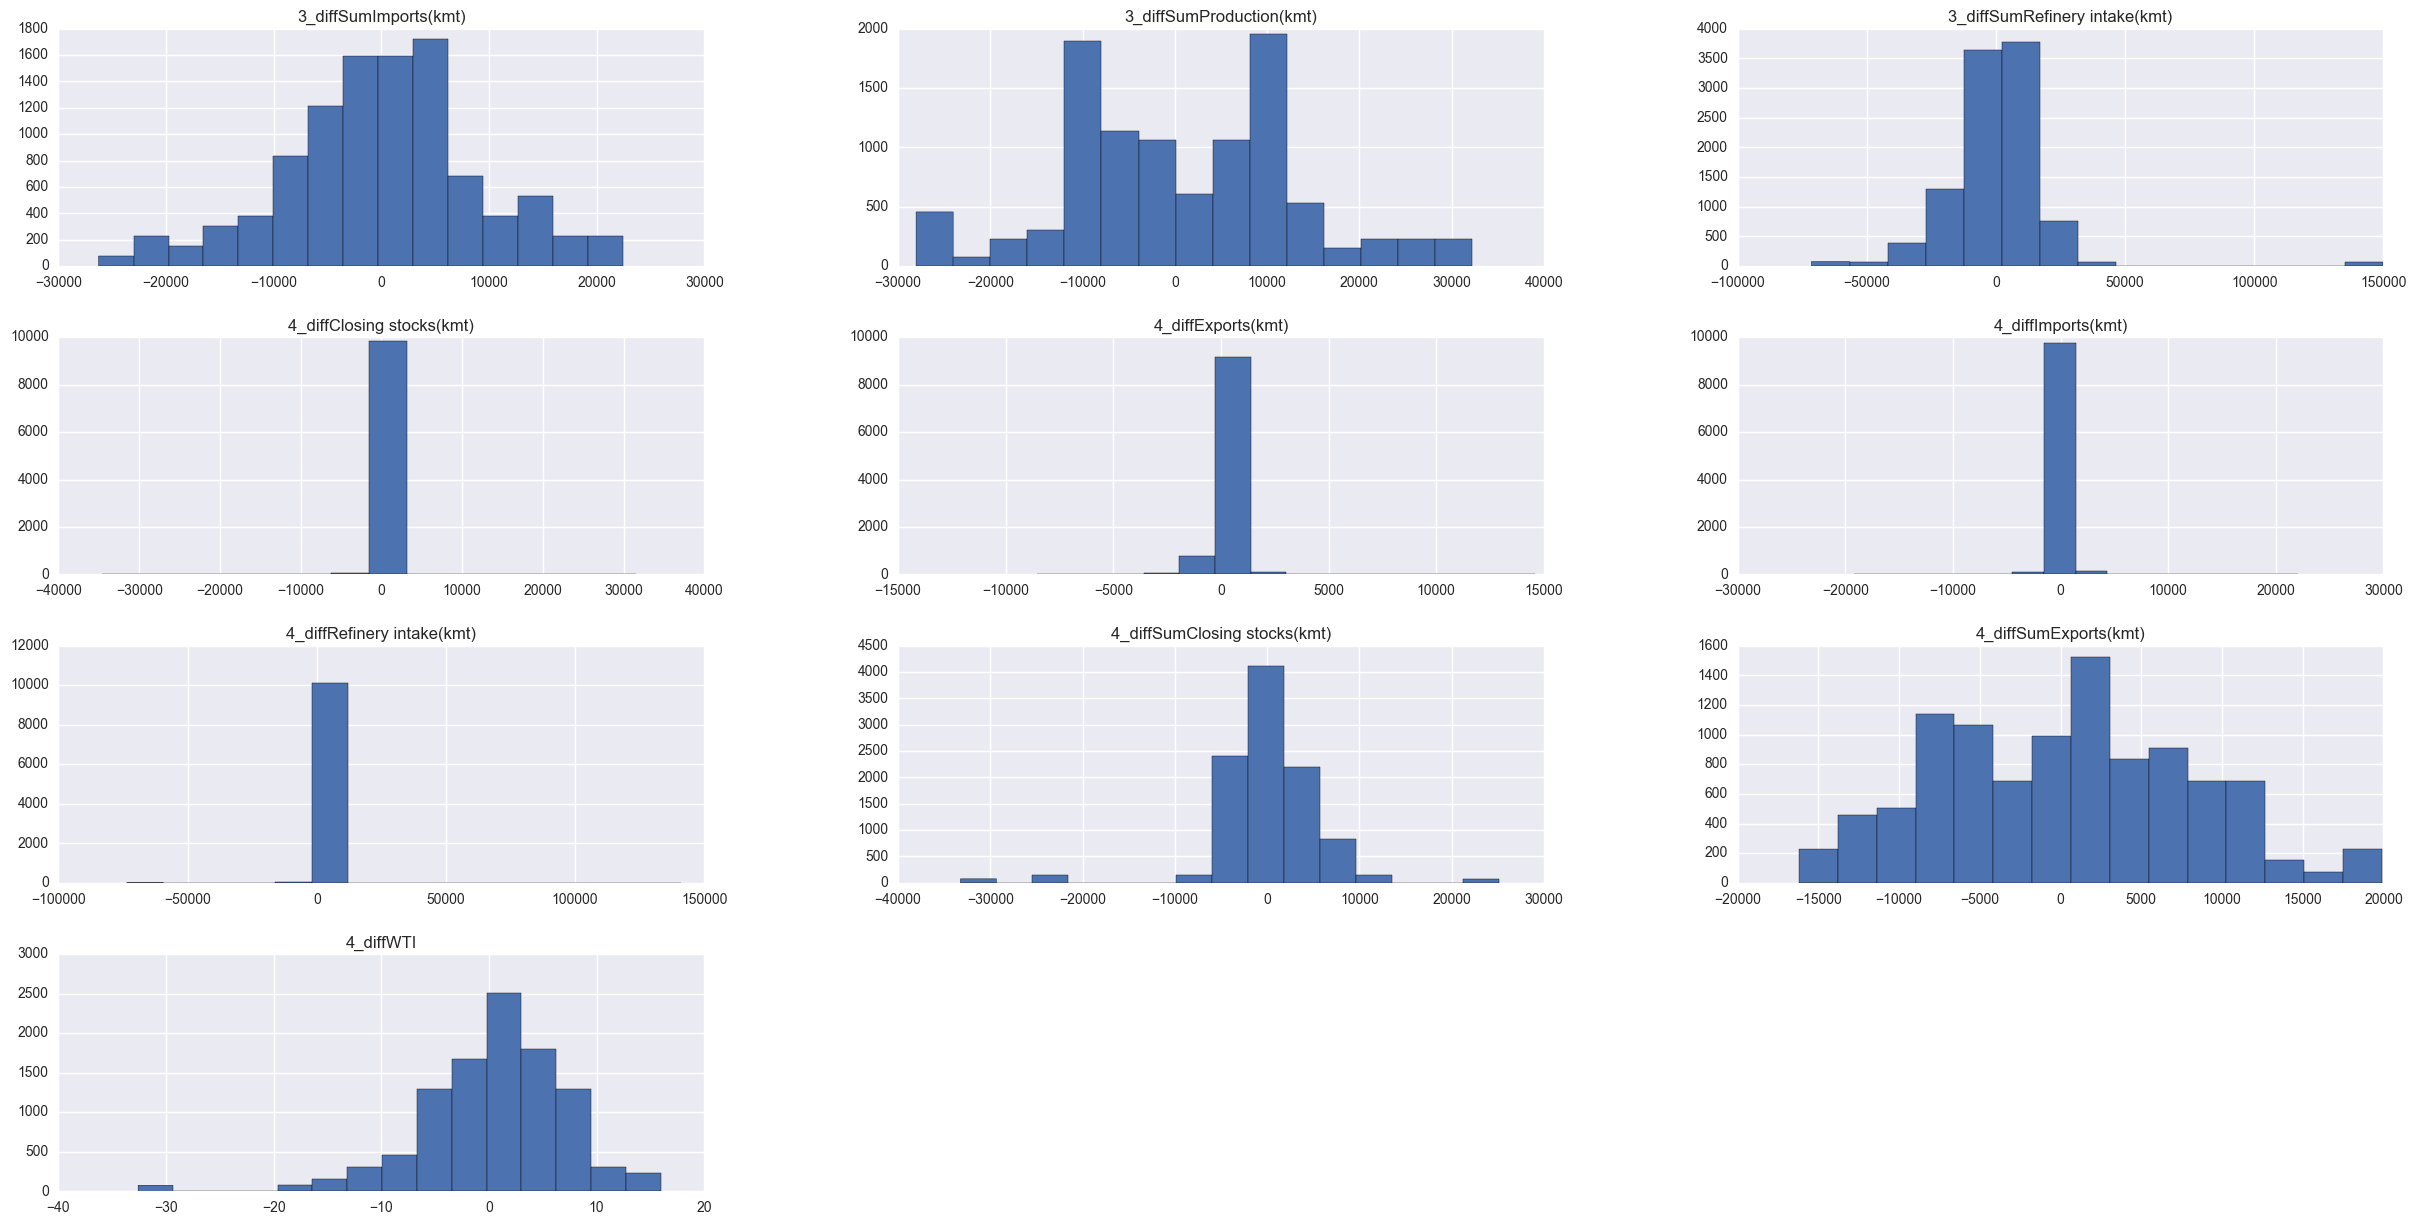

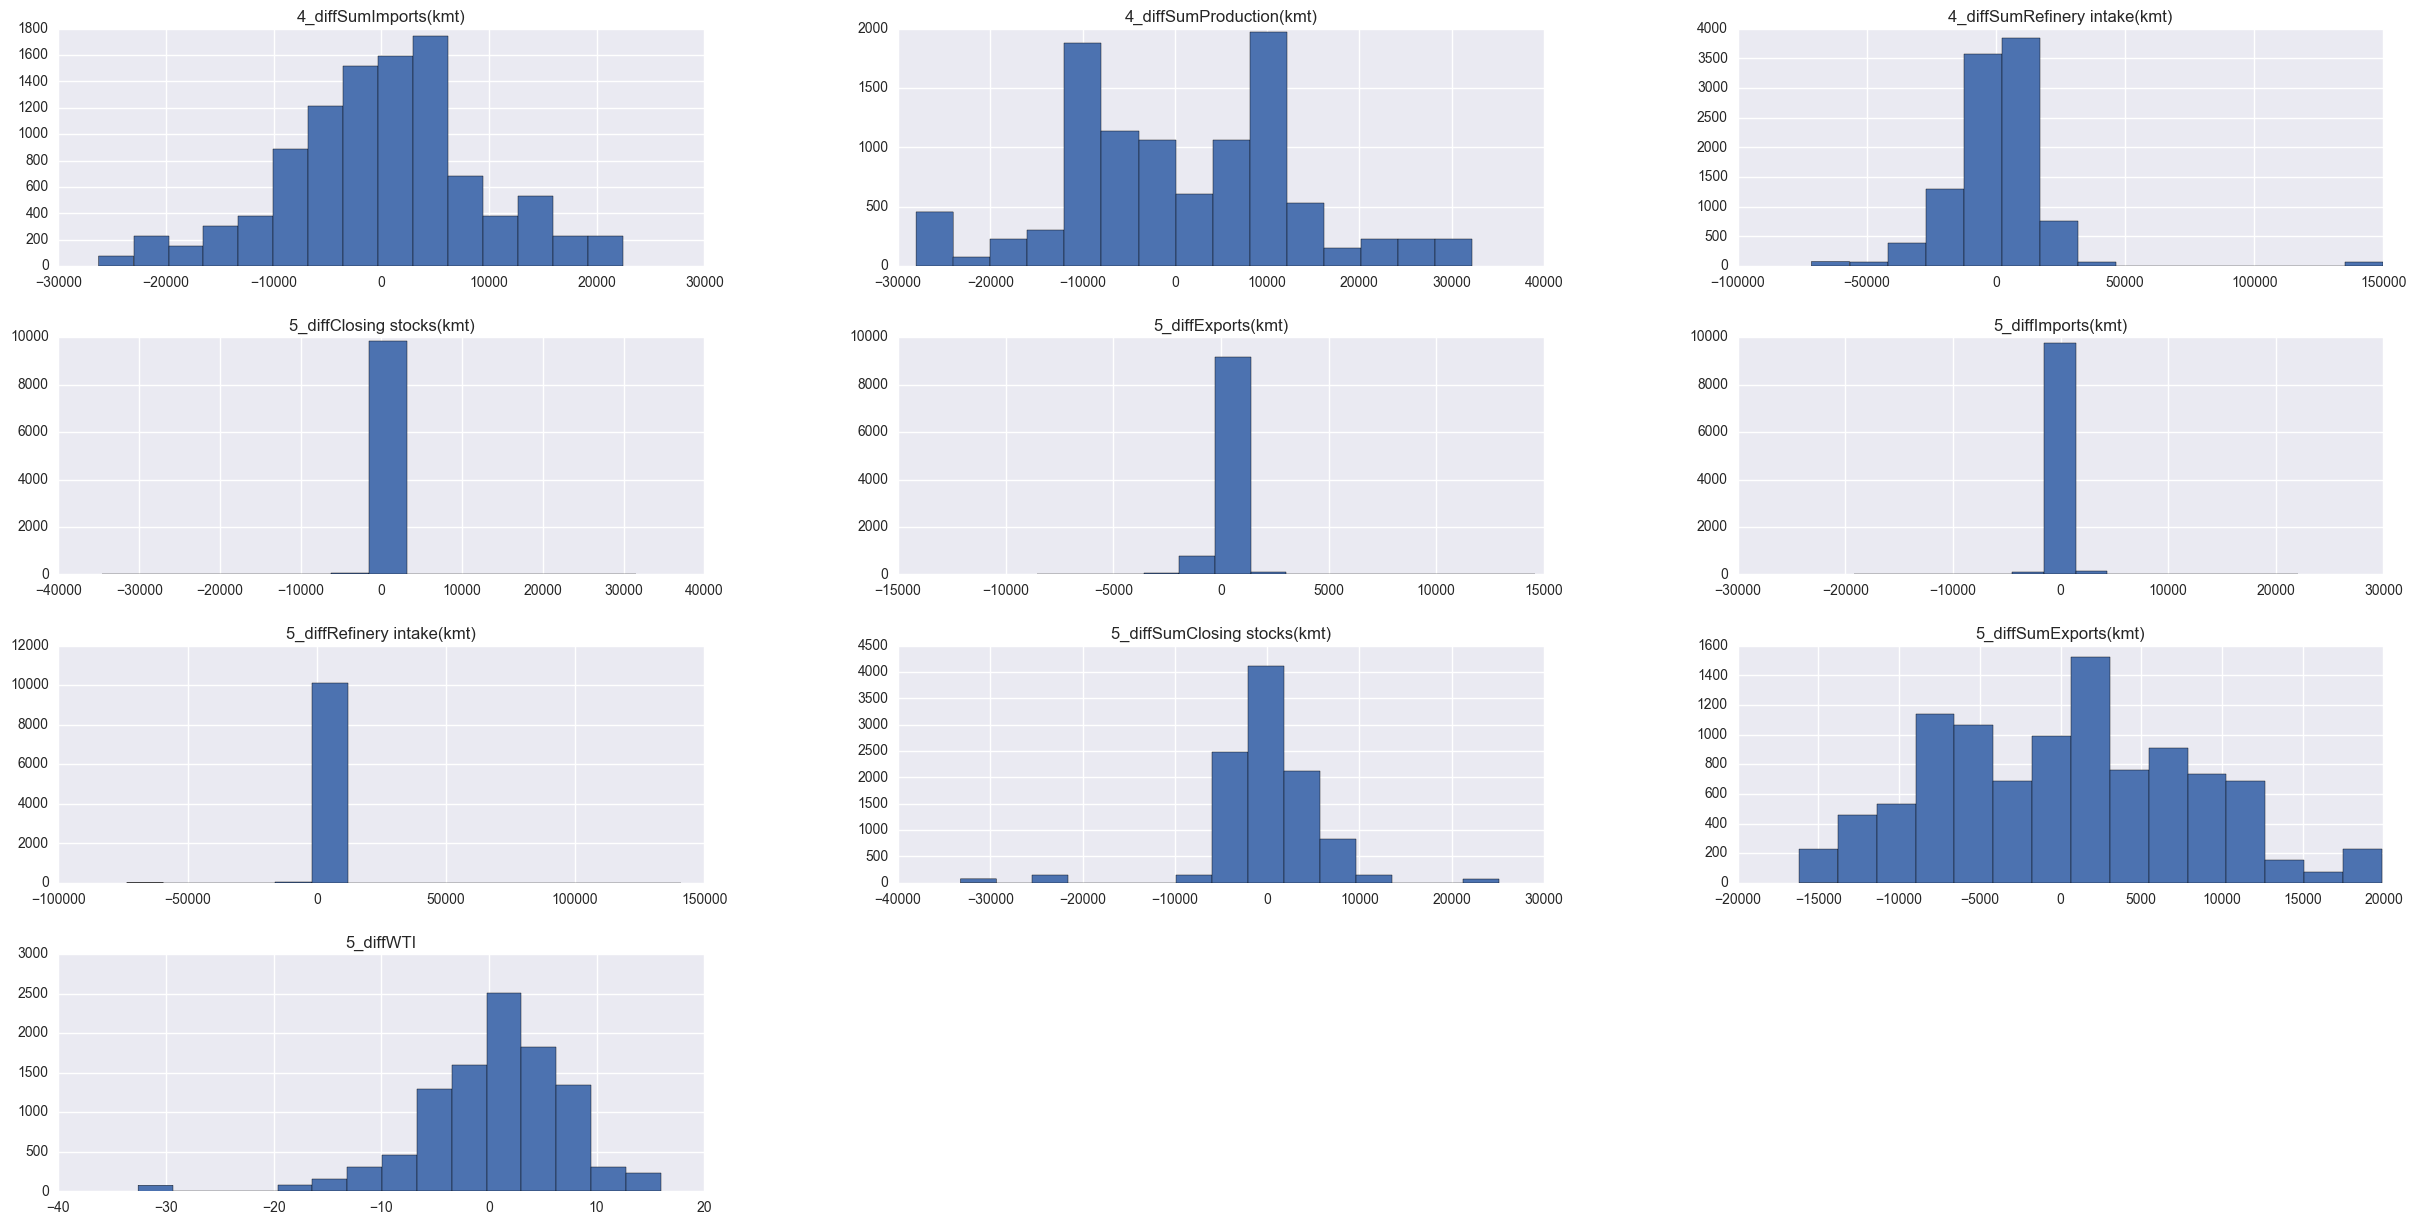

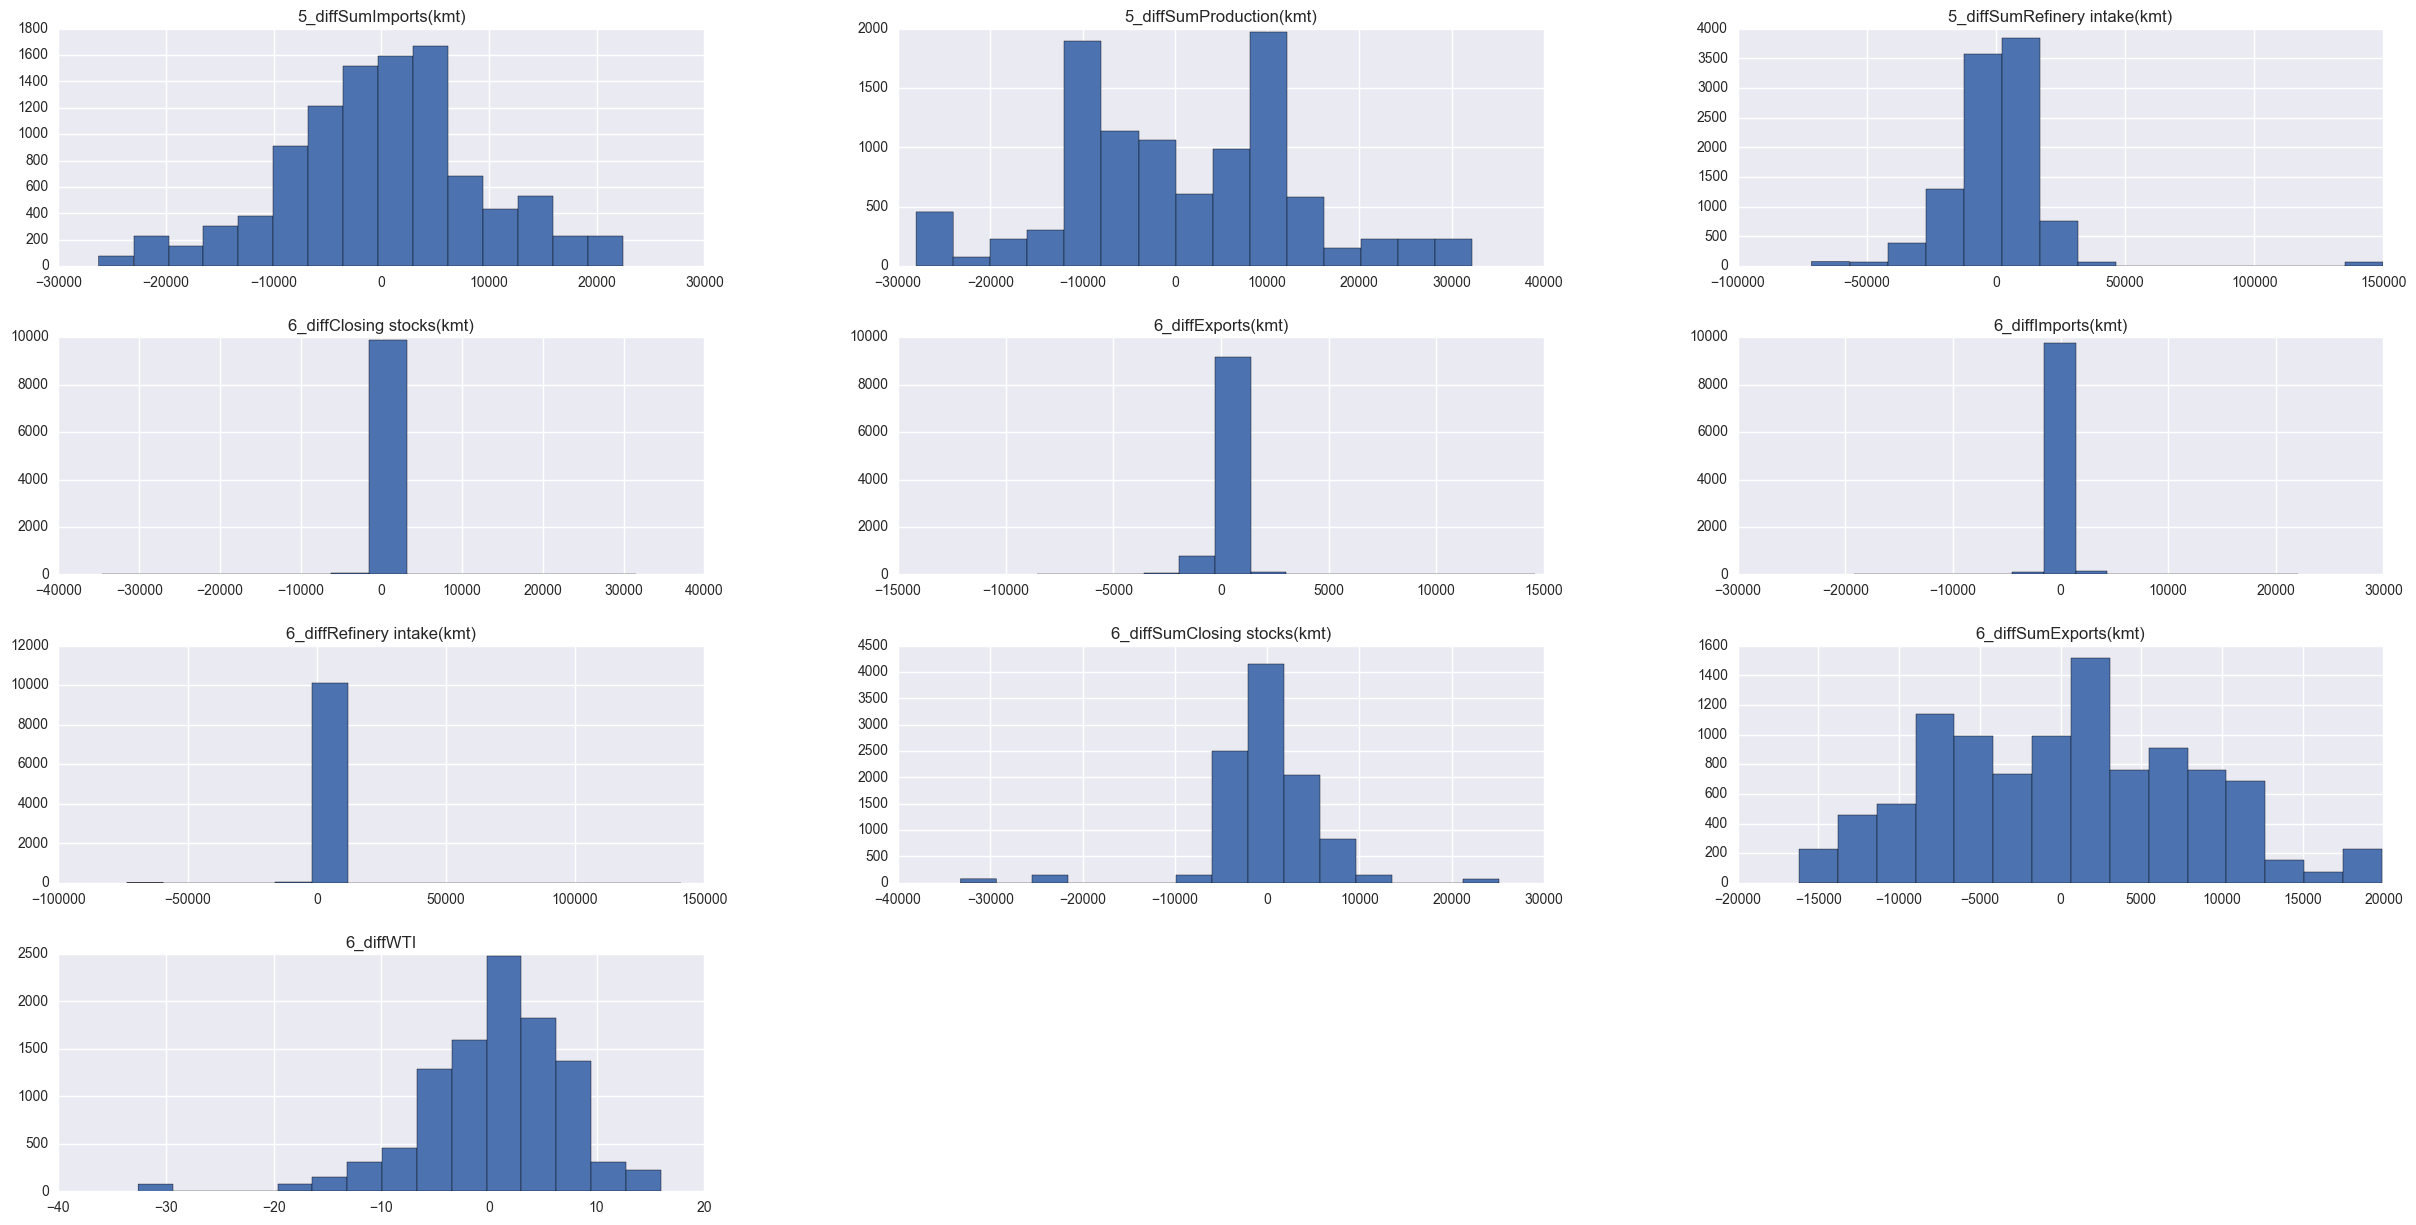

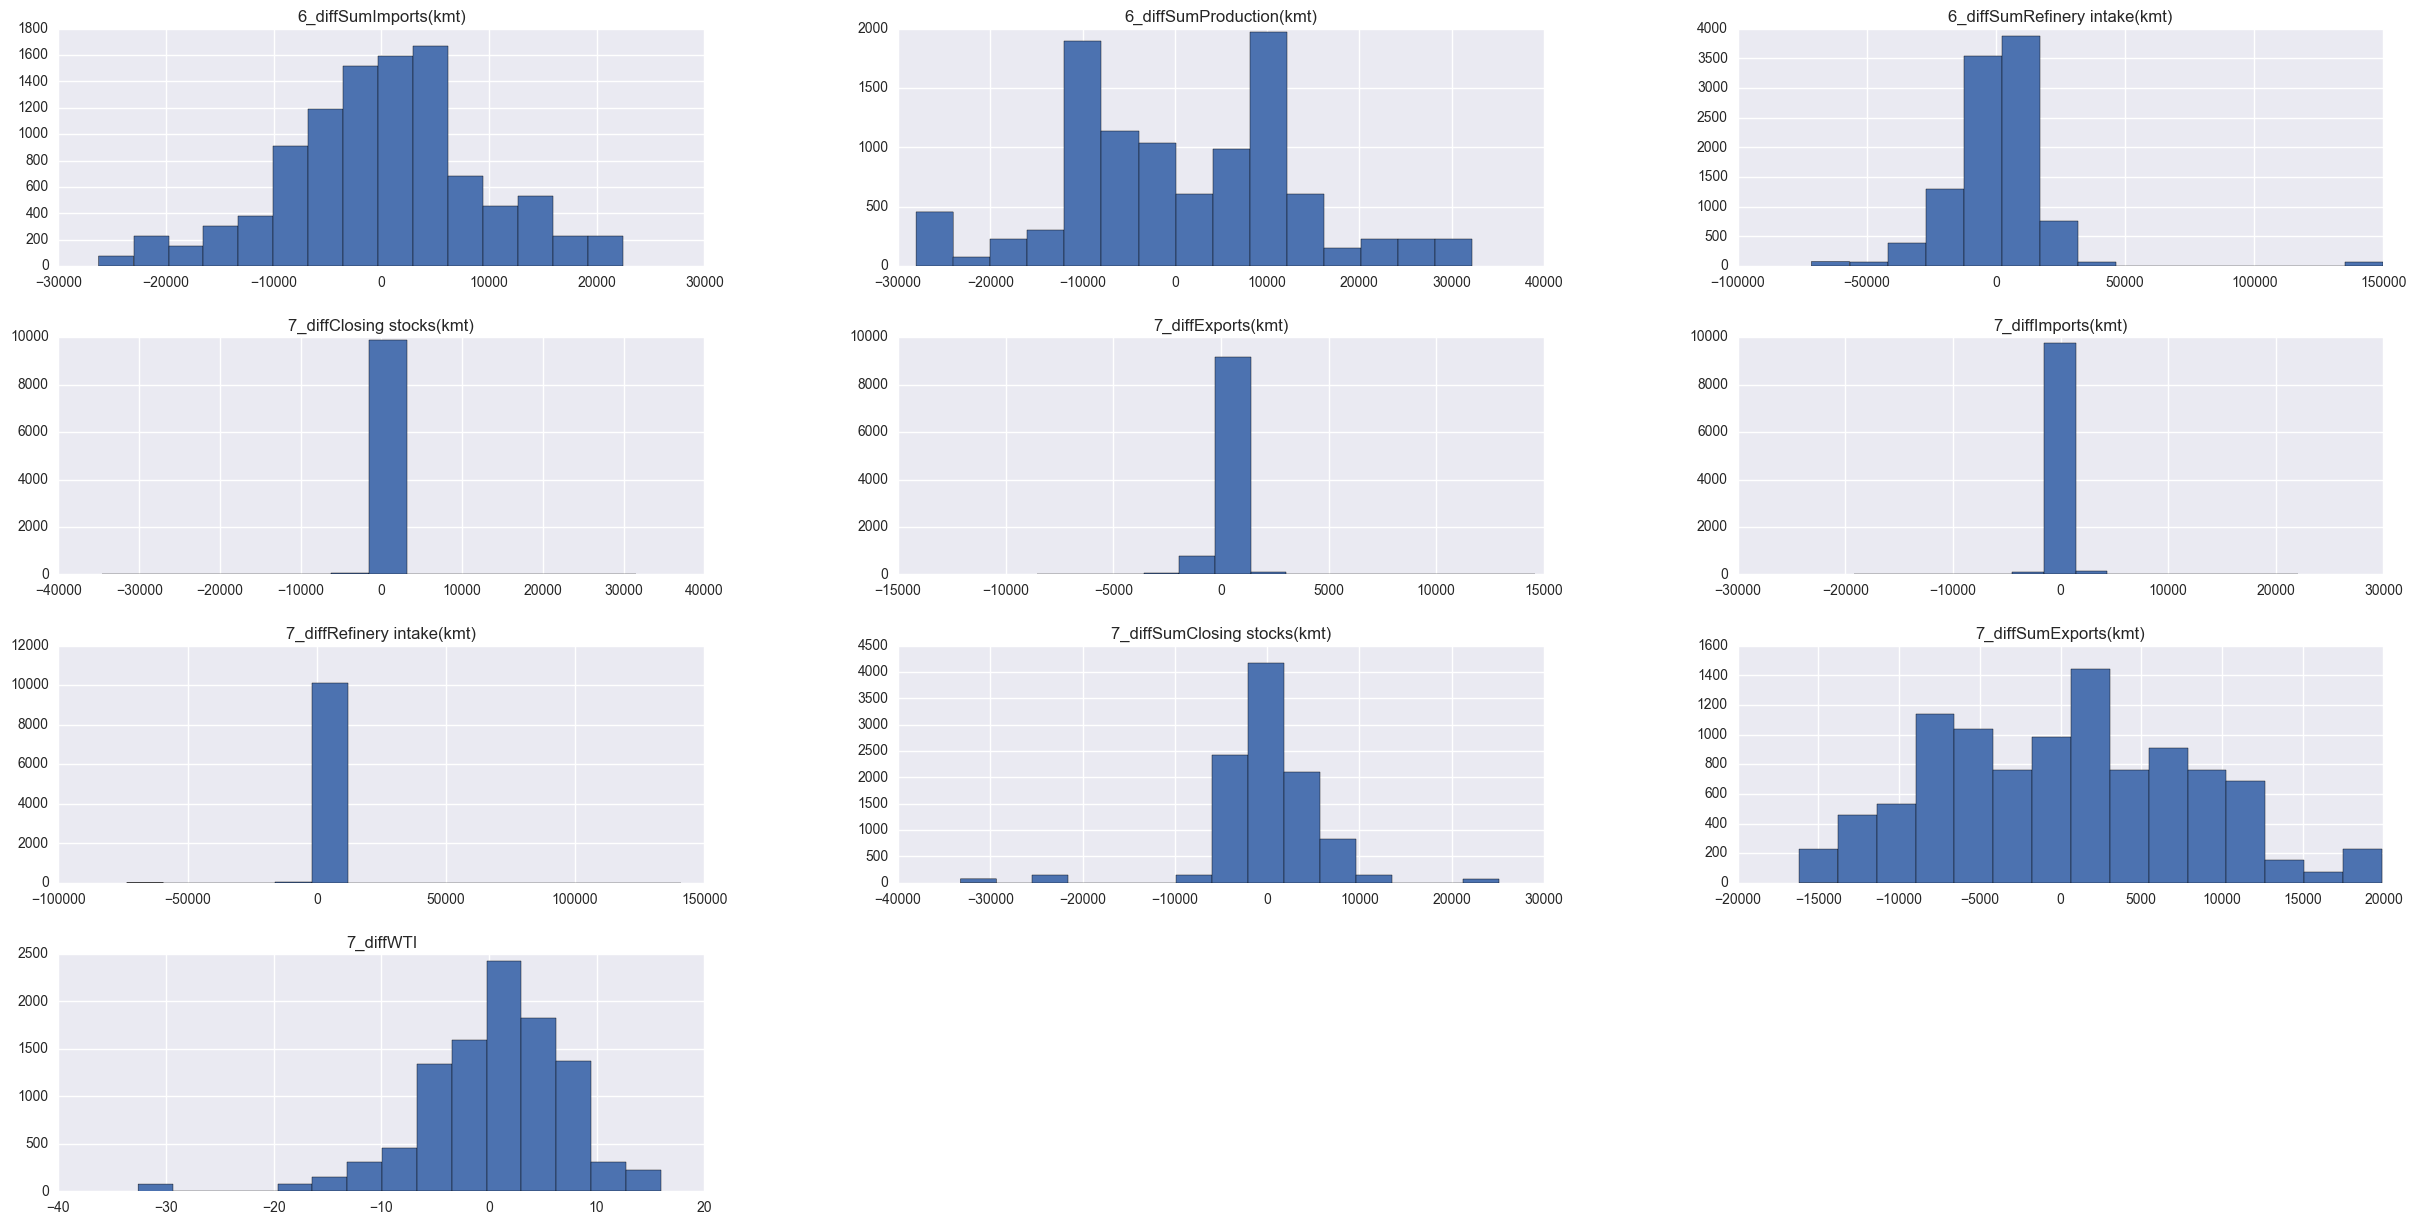

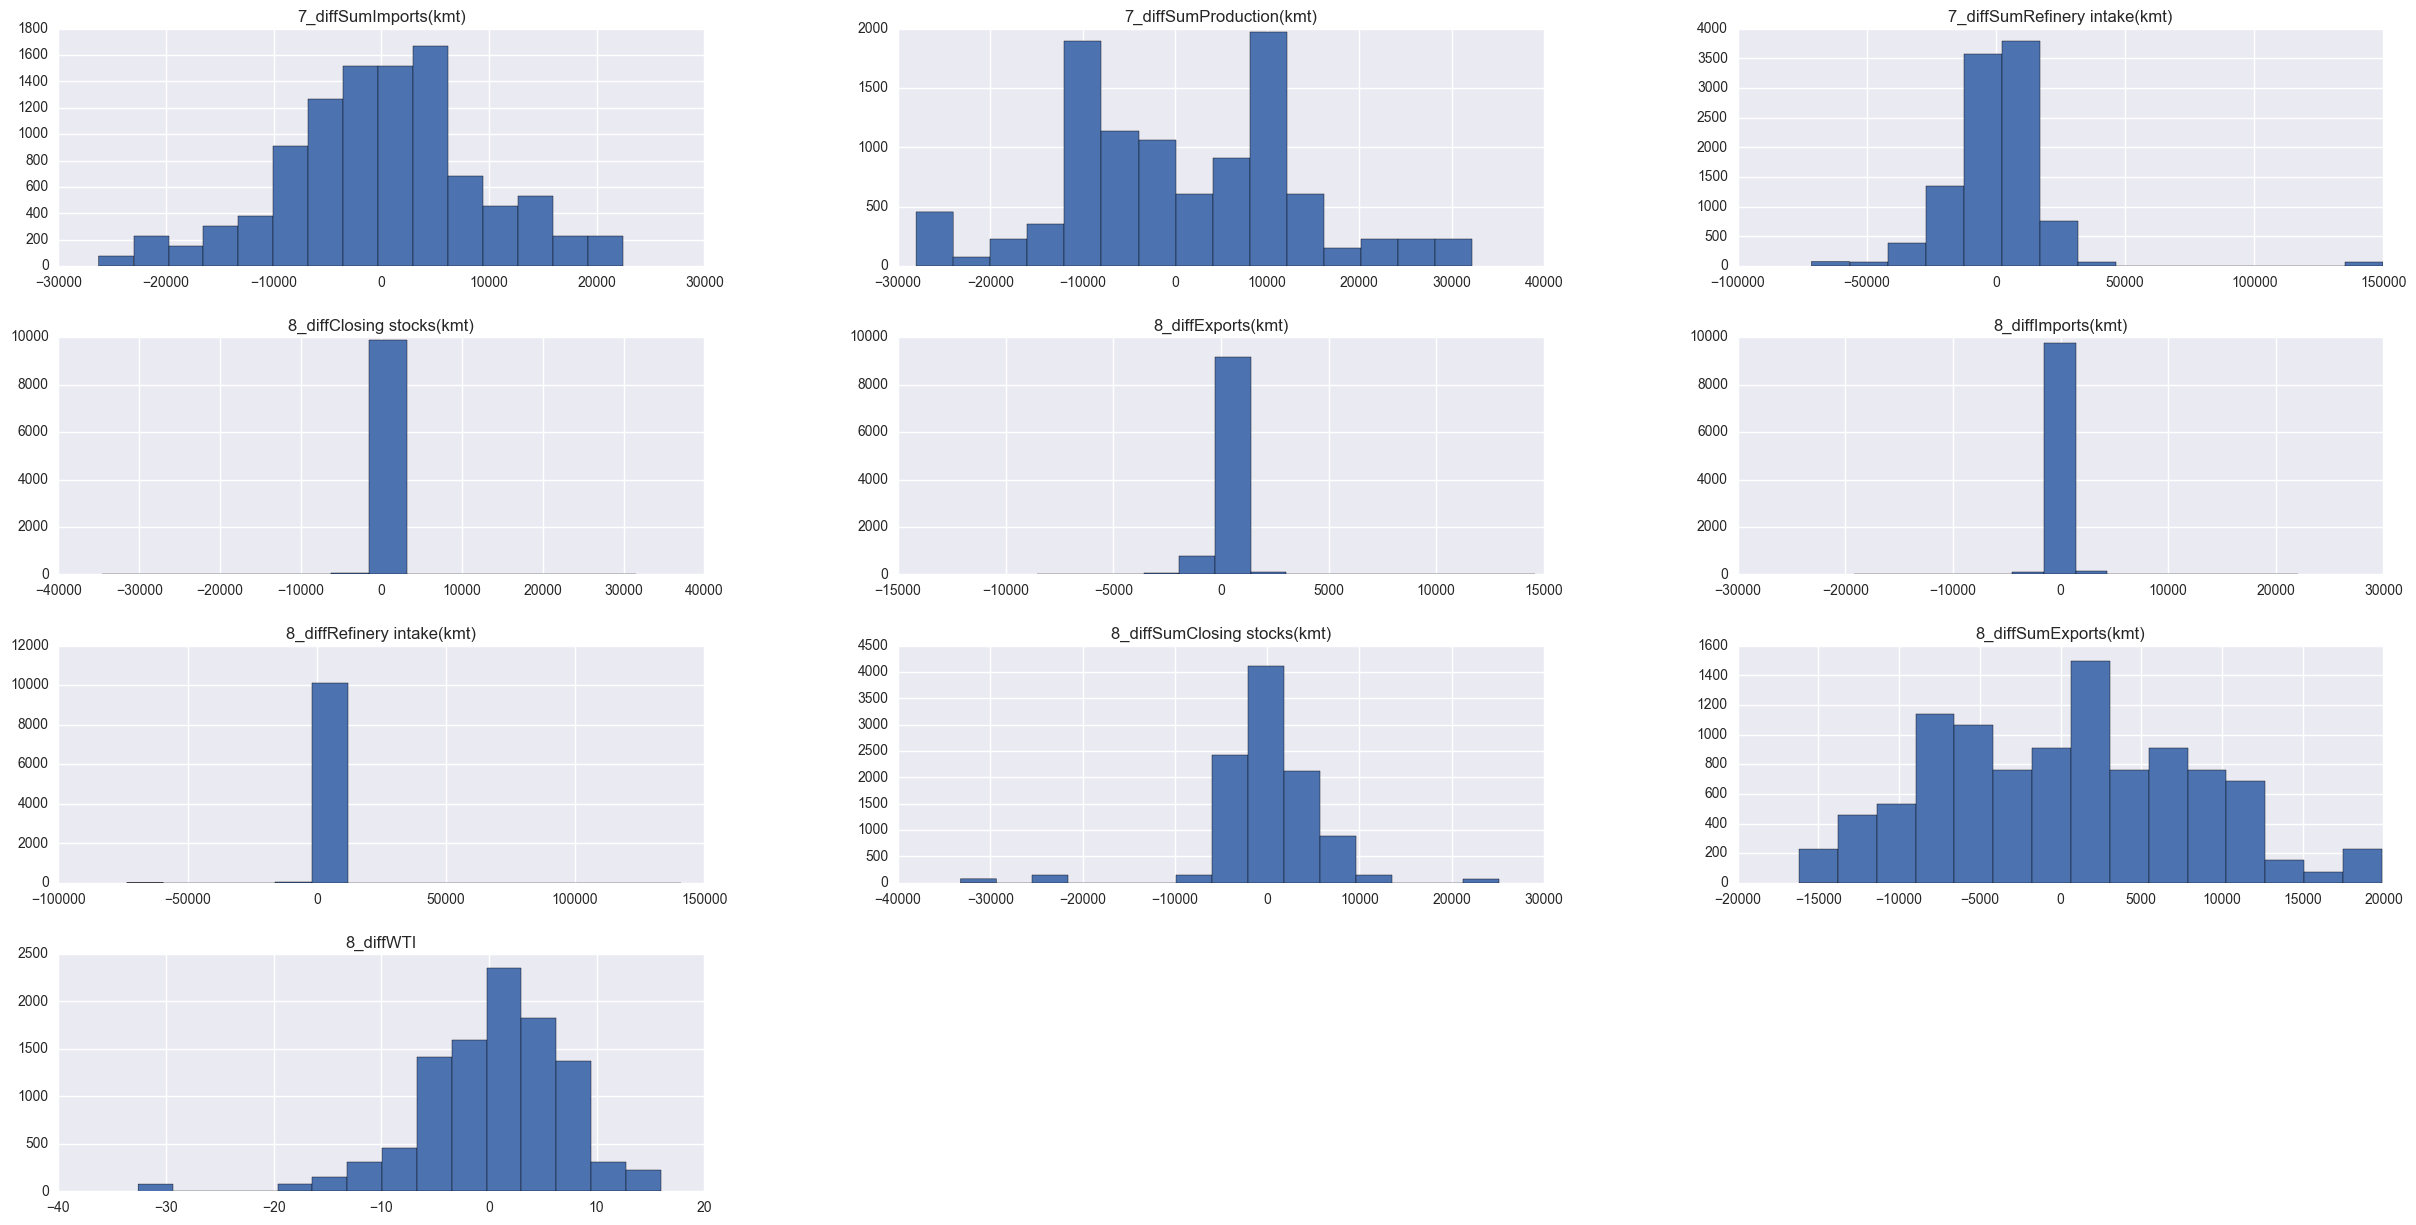

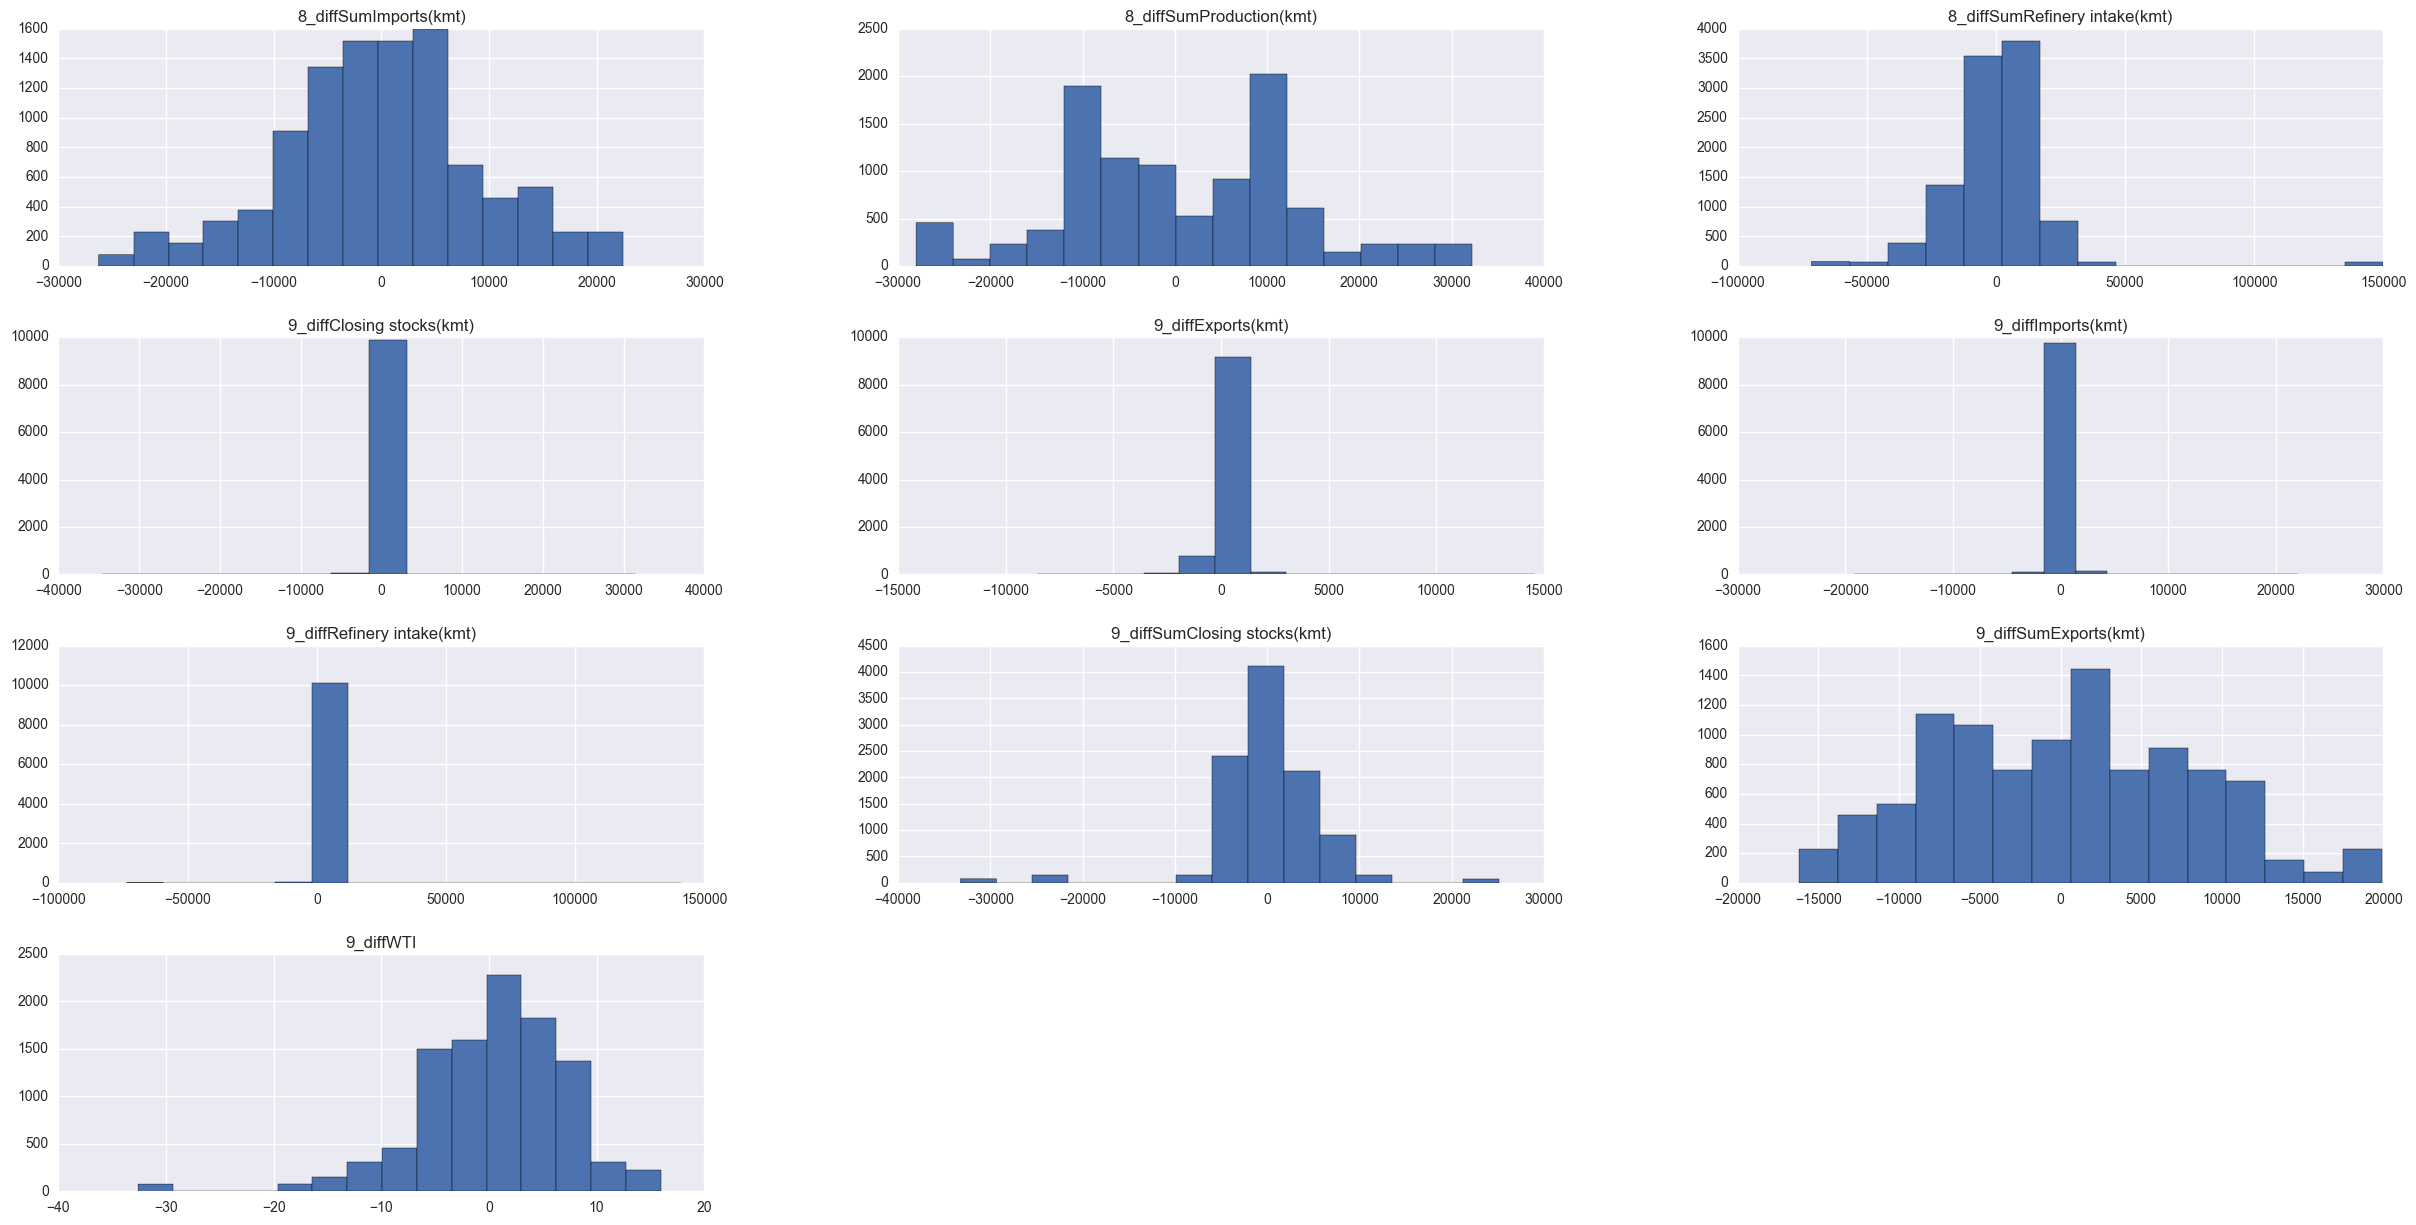

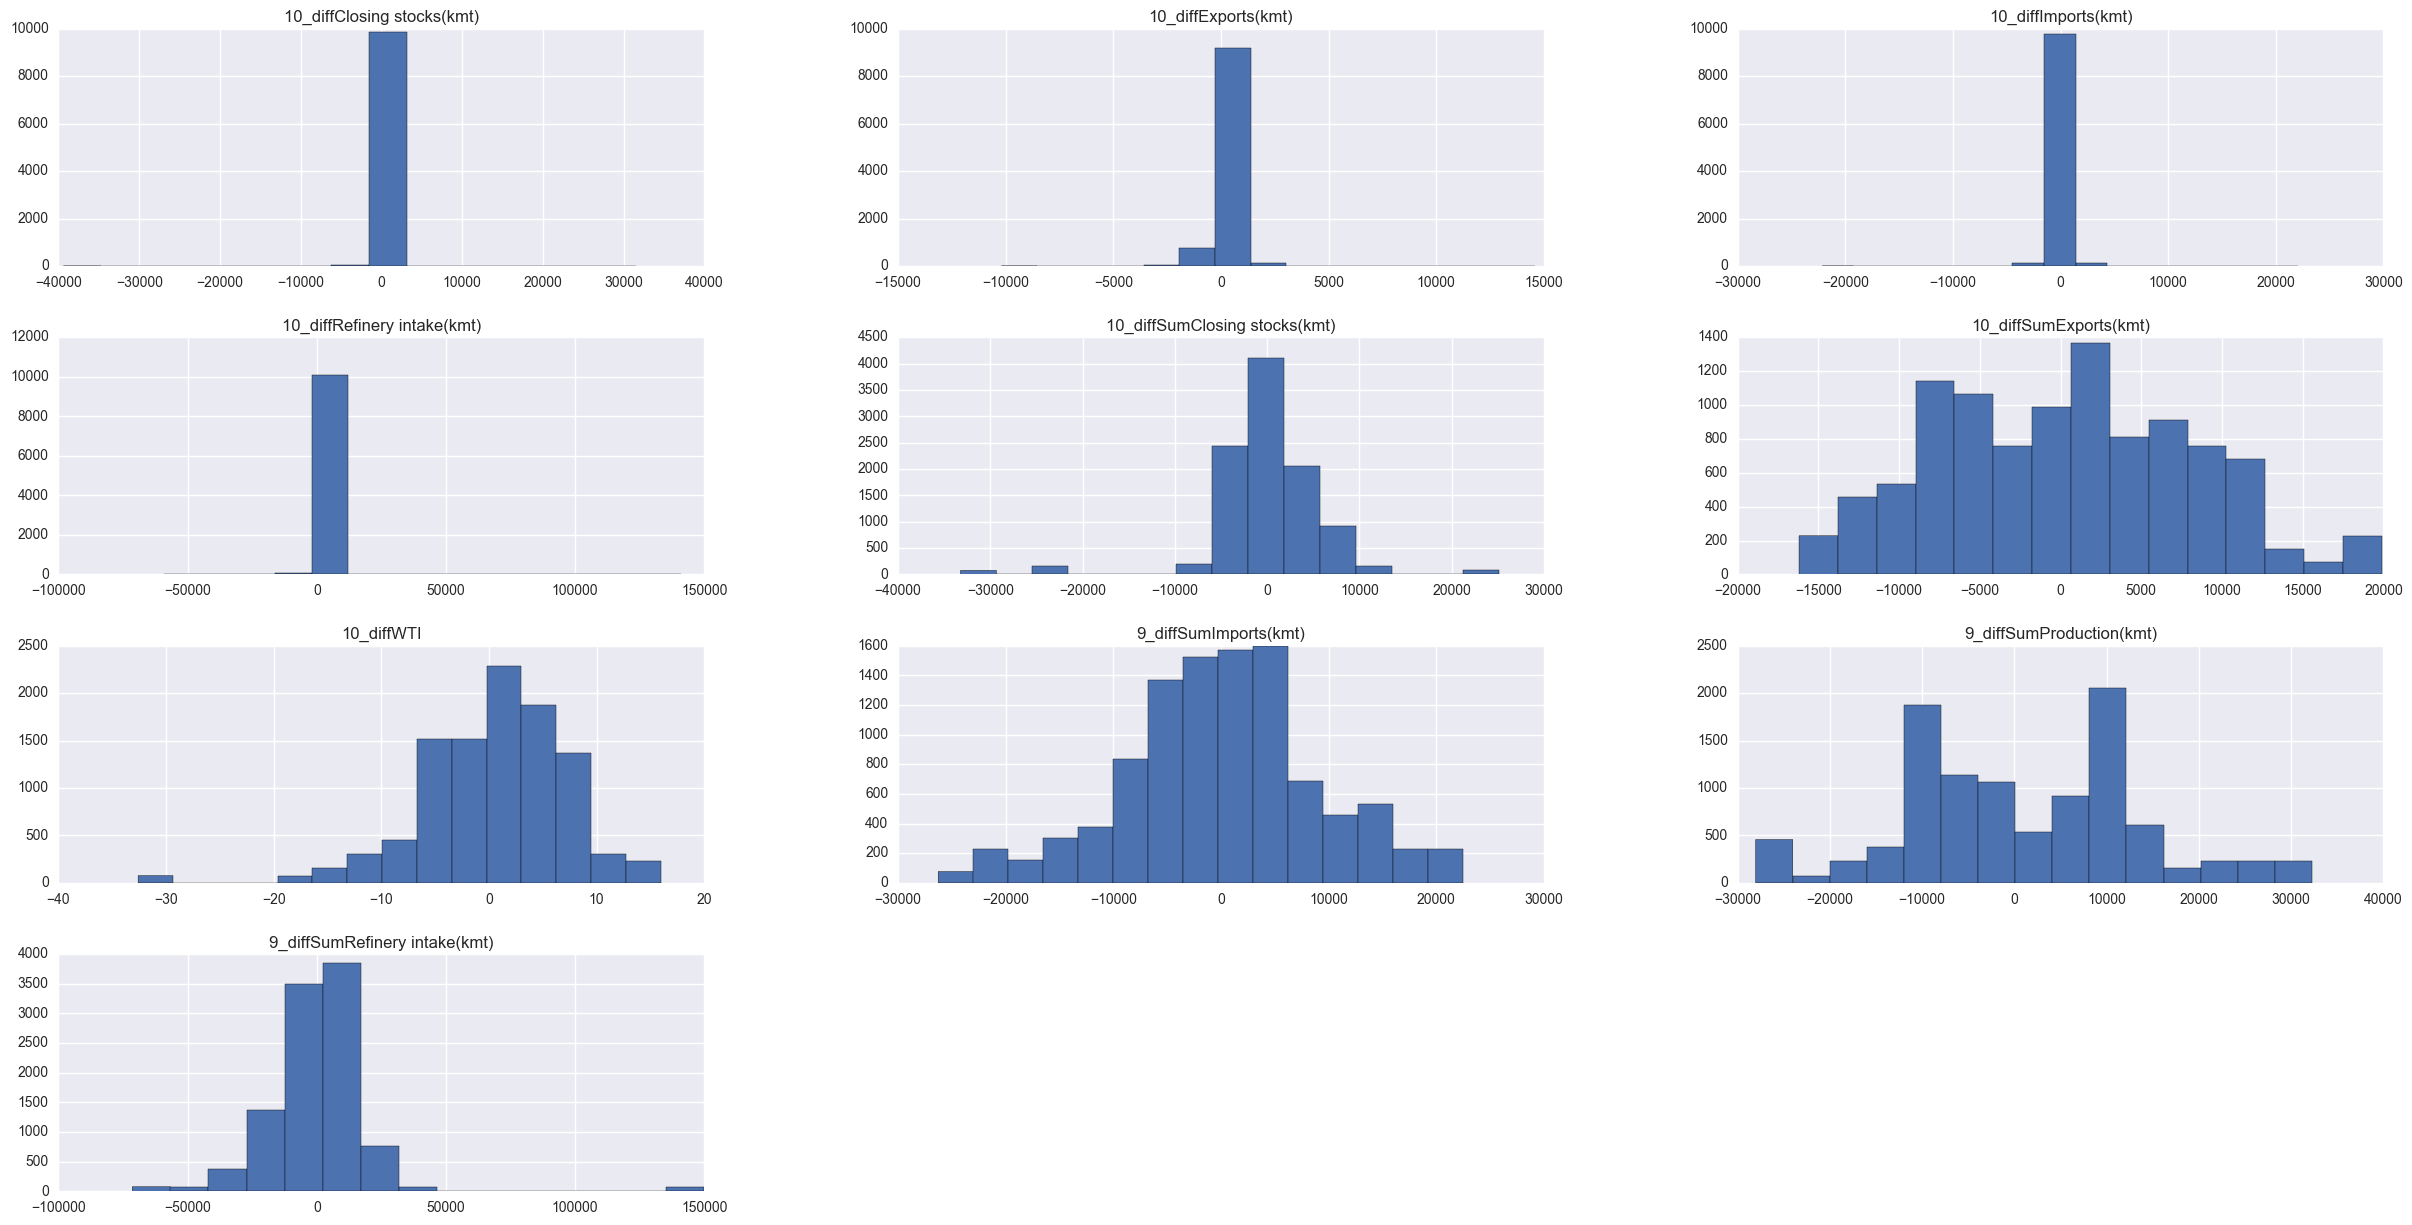

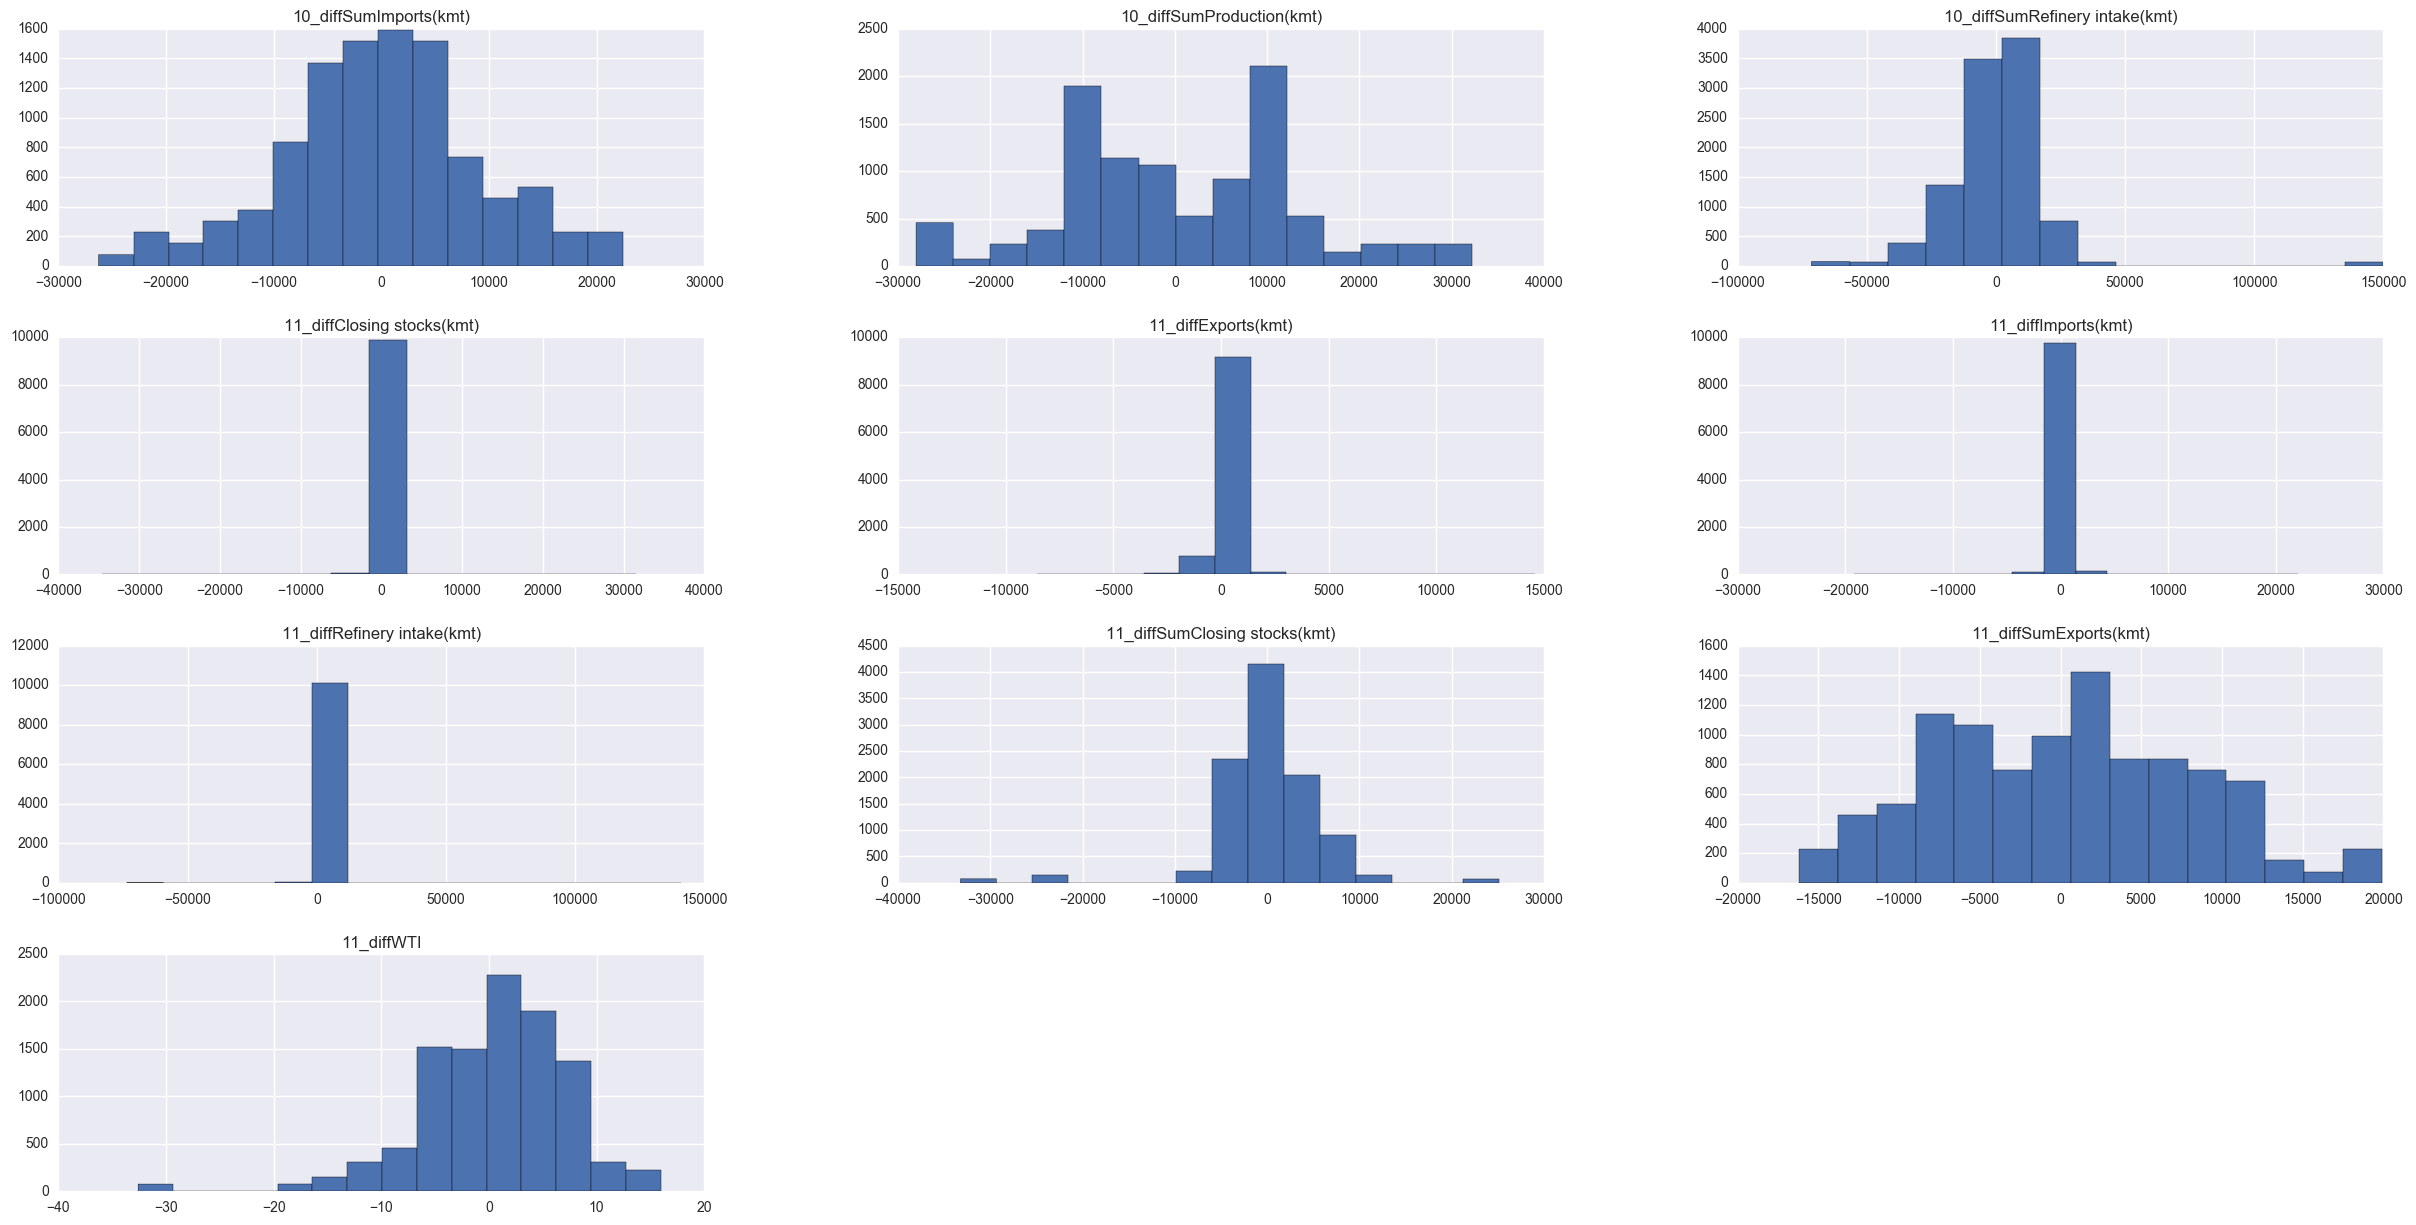

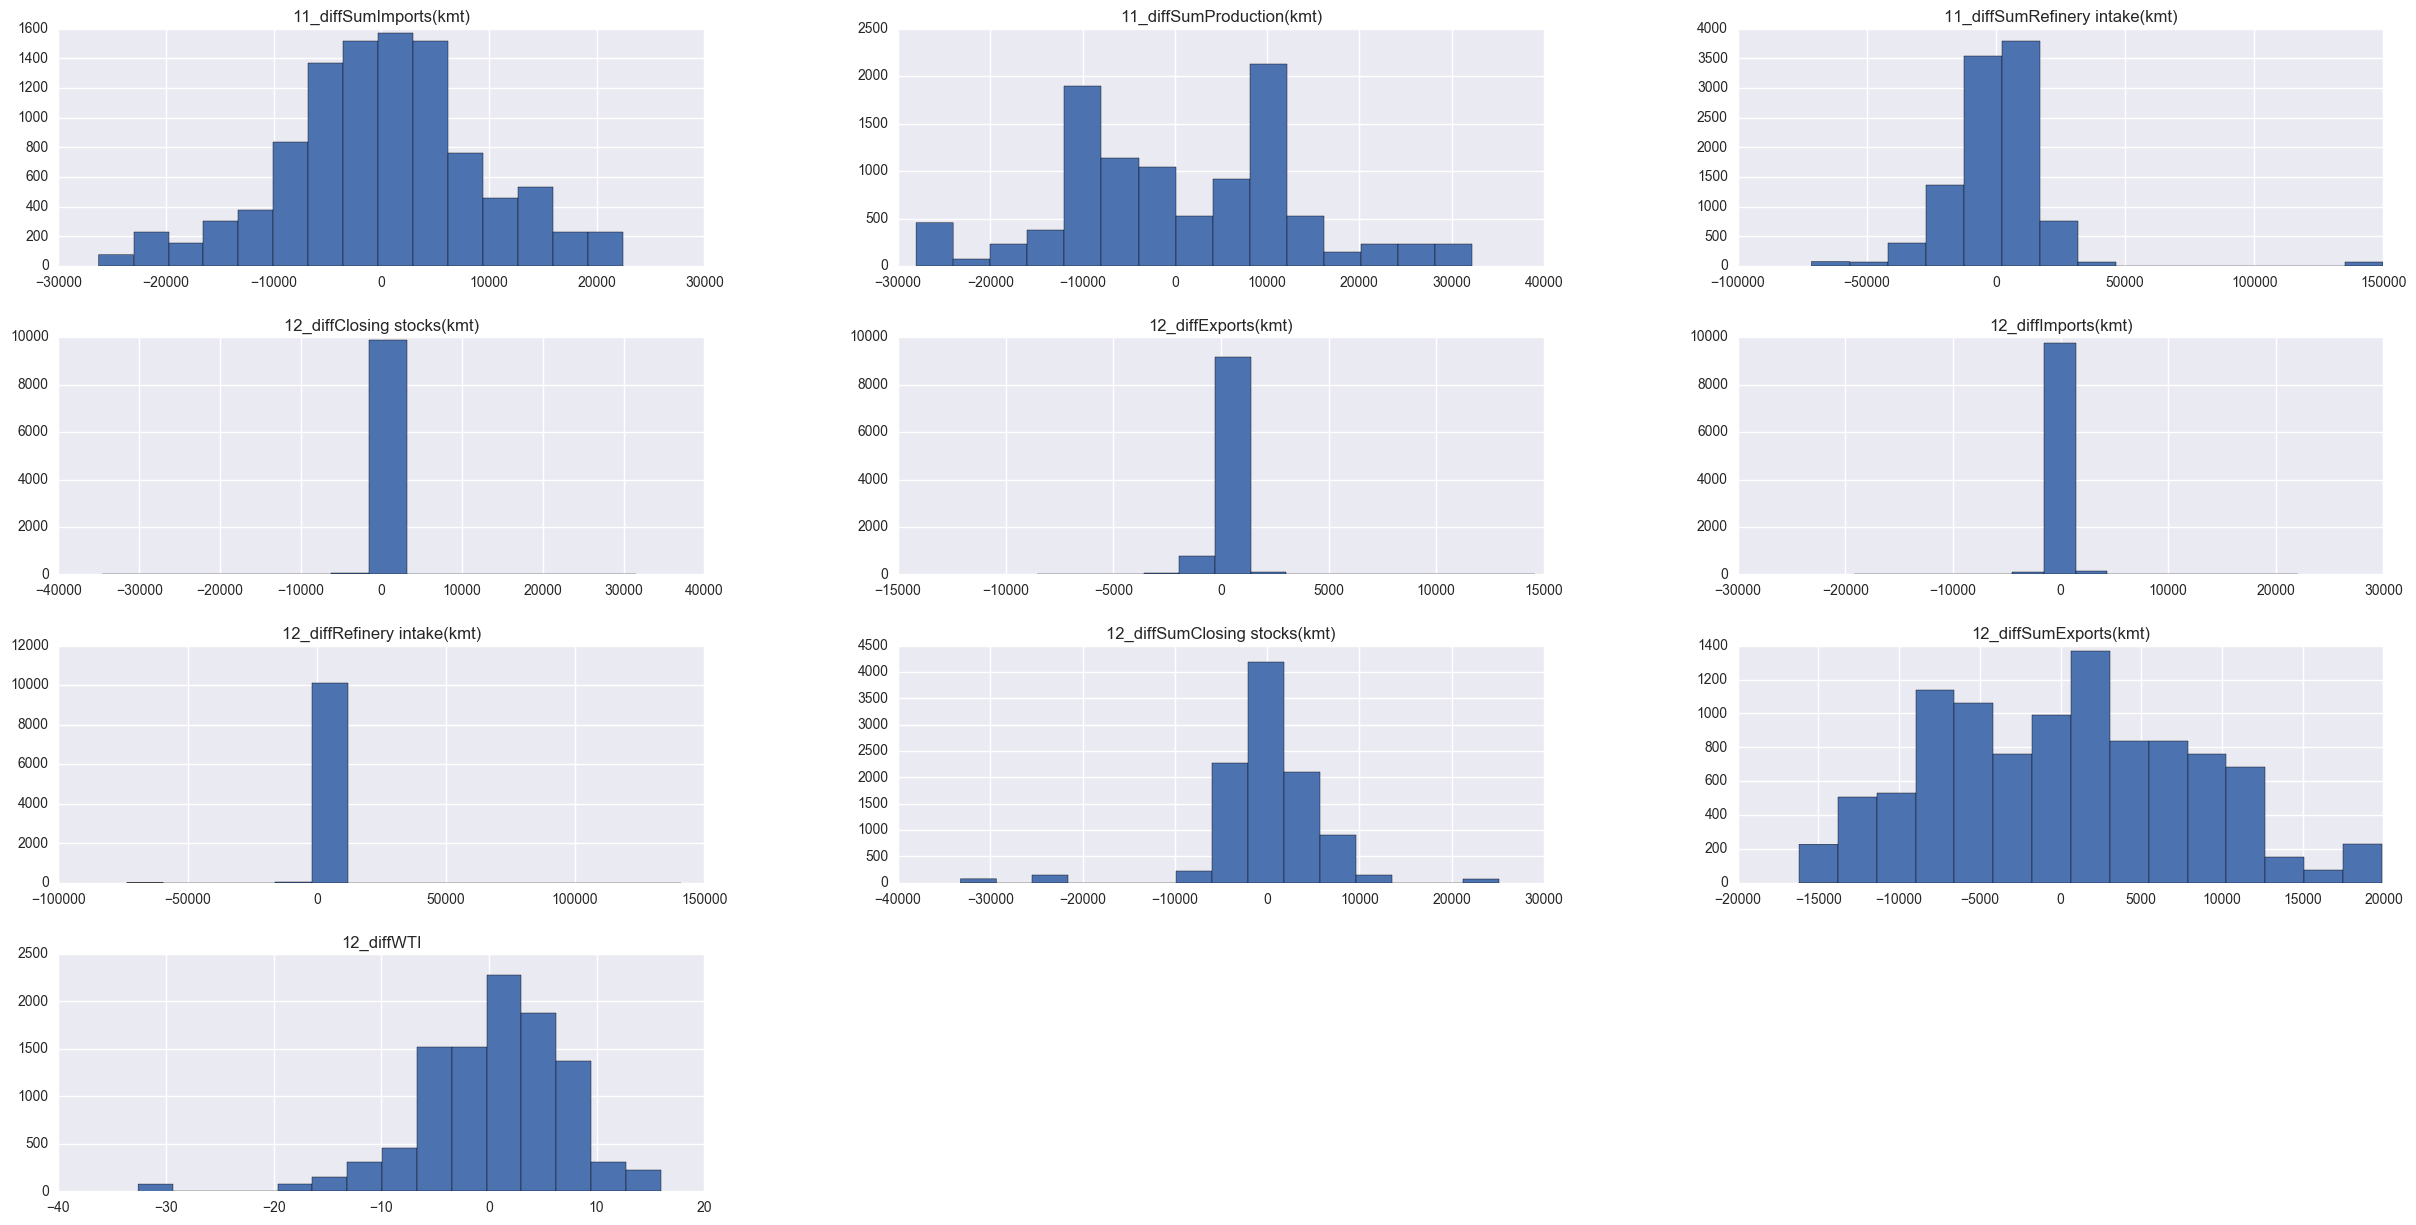

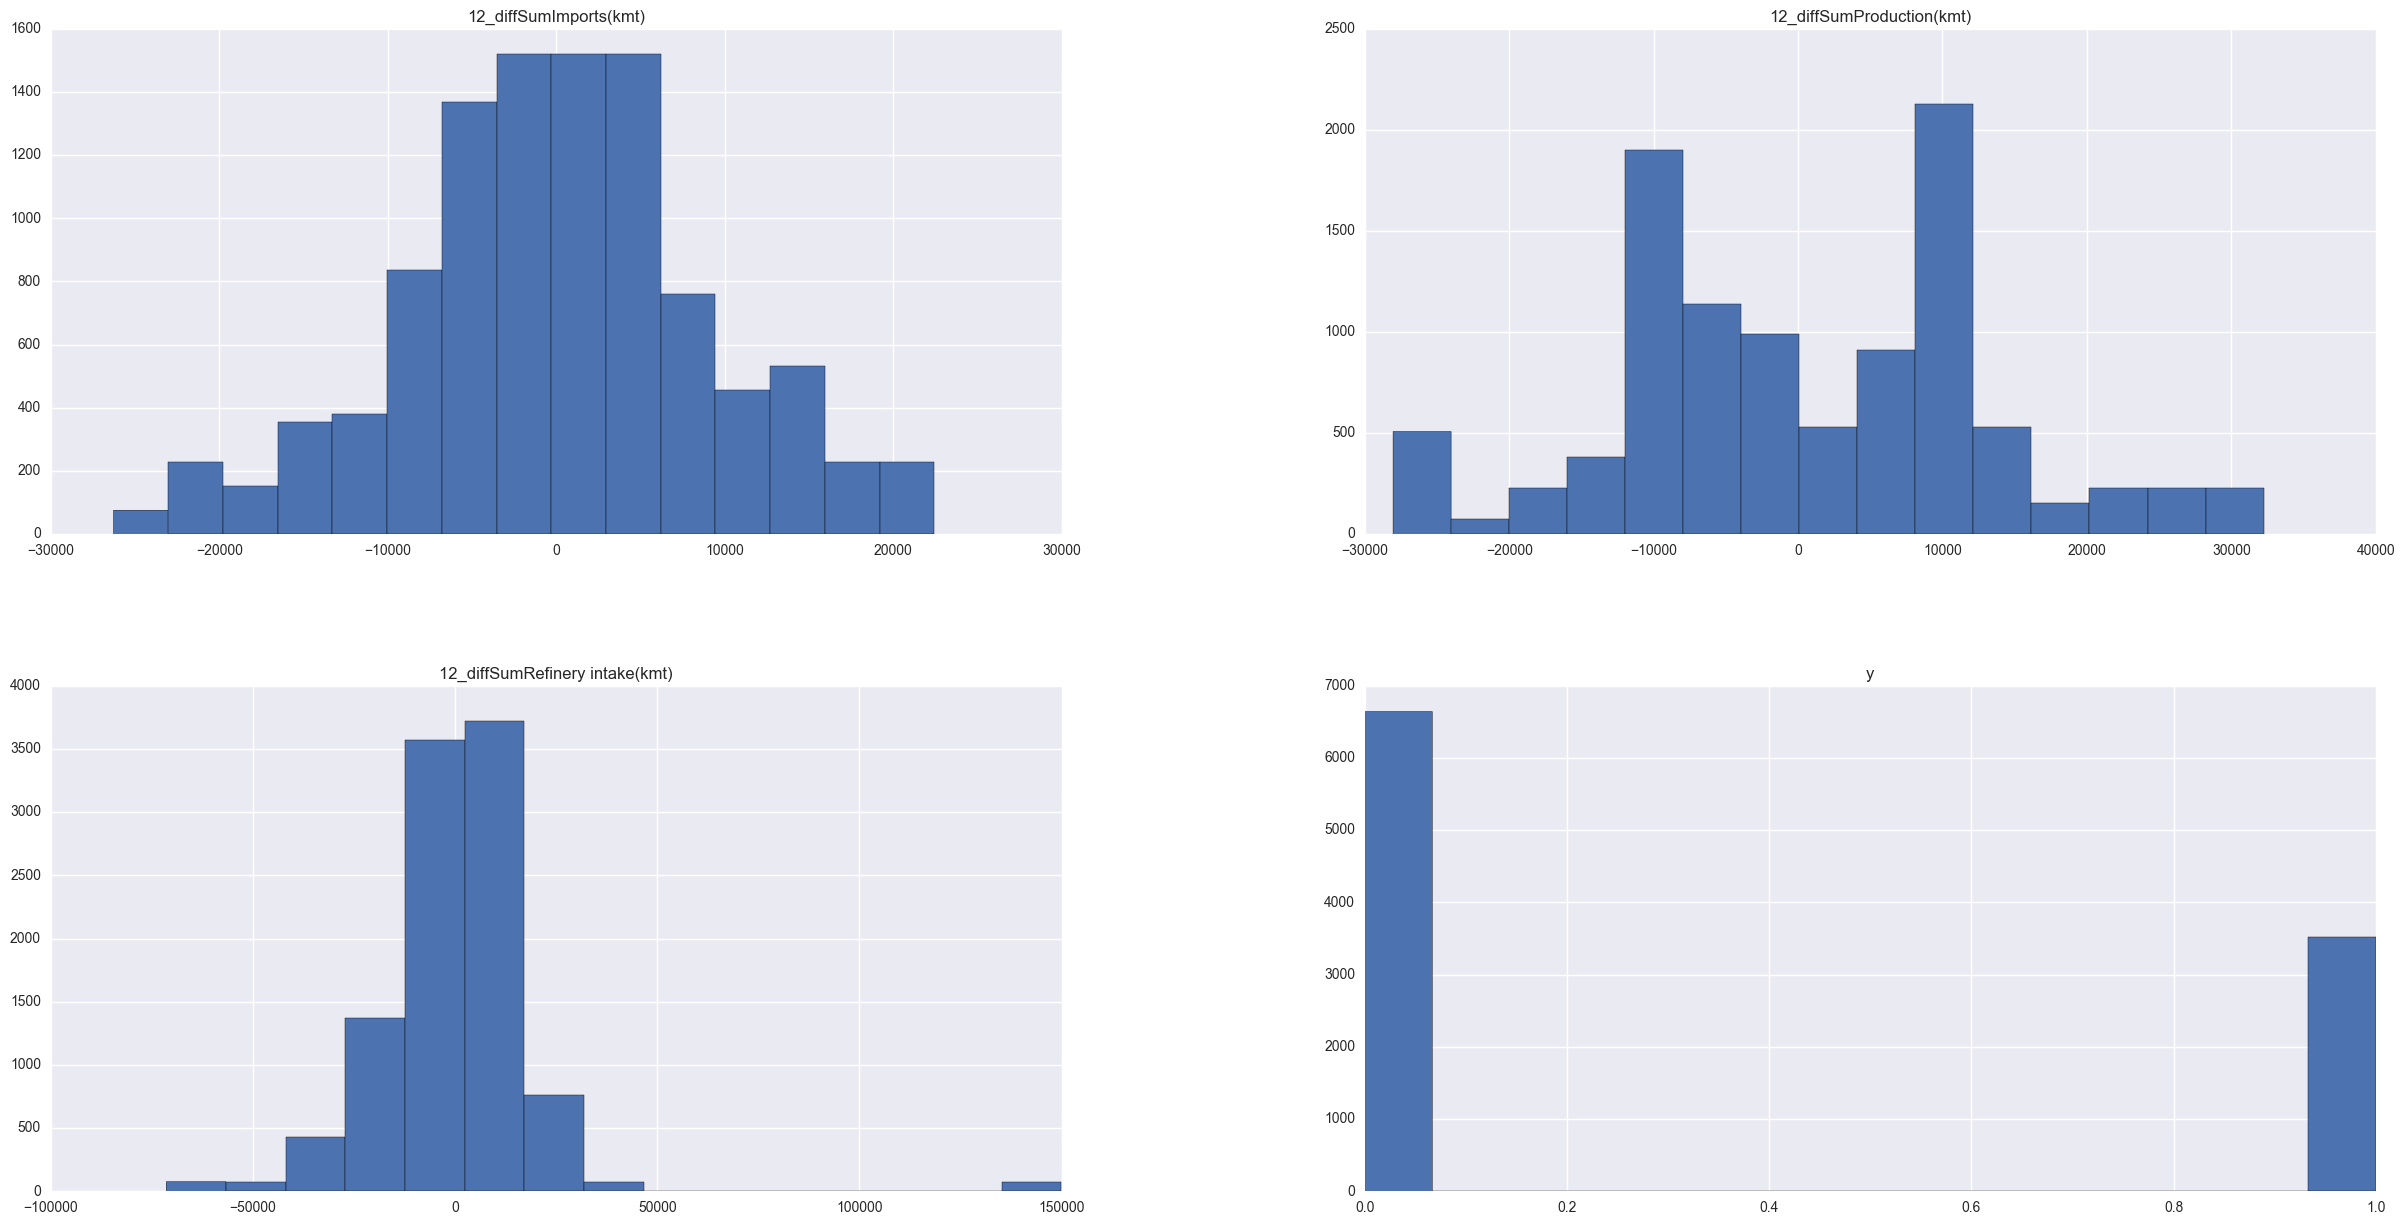

In [35]:
%%time
data_train.ix[:,:10].hist(bins=15, figsize=(30, 15));
data_train.ix[:,10:20].hist(bins=15, figsize=(30, 15));
data_train.ix[:,20:30].hist(bins=15, figsize=(30, 15));
data_train.ix[:,30:40].hist(bins=15, figsize=(30, 15));
data_train.ix[:,40:50].hist(bins=15, figsize=(30, 15));
data_train.ix[:,50:60].hist(bins=15, figsize=(30, 15));
data_train.ix[:,60:70].hist(bins=15, figsize=(30, 15));
data_train.ix[:,70:80].hist(bins=15, figsize=(30, 15));
data_train.ix[:,80:90].hist(bins=15, figsize=(30, 15));
data_train.ix[:,90:100].hist(bins=15, figsize=(30, 15));
data_train.ix[:,100:110].hist(bins=15, figsize=(30, 15));
data_train.ix[:,110:120].hist(bins=15, figsize=(30, 15));
data_train.ix[:,120:].hist(bins=15, figsize=(30, 15));

### PCA vizualization

Explained variance =  41.2407548845


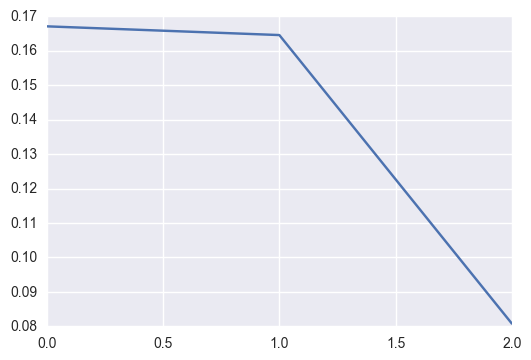

In [99]:
pca = PCA(n_components=3)
Y = pca.fit_transform(data_train.drop(["ID","month", "country","y"], axis=1).dropna())
print "Explained variance = ", 100 * pca.explained_variance_ratio_.sum()
plt.plot(pca.explained_variance_ratio_);

Our % of explained variance with a three-components PCA is only 41%, which entails that this PCA does not accurately represent our data.  
Nonetheless, let us see what it gives in 3D.

In [111]:
import plotly.offline as py
import plotly.graph_objs as go

import numpy as np
trace1 = go.Scatter3d(
    x=Y[:,0],
    y=Y[:,1],
    z=Y[:,2],
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        color=data_train.y.tolist(),
        opacity=0.8,
#        colorscale='Viridis'
         colorbar=go.ColorBar(
                title='Colorbar'
            ),
    ),
#    text=data_train.y.astype(str),
#    hoverinfo='text',
    name='3D PCA'
)

data = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    title='3D PCA vizualization',
    scene=go.Scene(
    xaxis=dict(
        title='1st PCA component',
    ),
    yaxis=dict(
        title='2nd PCA component',
      ),
    zaxis=dict(
        title='2nd PCA component',
    )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3D PCA vizualization')

- 1 plan gathers data

## 3. Modelization
We have to find the most performant model based on the data we have.  
To this end, we need to define a metric, adapted to our problem and avoid overfitting.
### Metric choice
Metric choice depends entirely on what we want to achieve with our modelization.  
Several metrics are commonly used for classification problems :
- MSE
- Precision or recall on one class
- Area Under Receiver Operating Characteristics (AUROC) which esteems model's performance for both classes (great blog on AUC and its different interpretations) : http://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it
- Many other.. : http://scikit-learn.org/stable/modules/model_evaluation.html

As we have no more details on the modelization's goal, we will use the AUROC metric.  
Our choice could definitely have been different, e.g. if we wanted to achieve a very high accuracy on countries with increasing oil production, we would have chose a metric offering a greater precision on people belonging to class 1. 

In [49]:
%%time
xgbclf = xgb.XGBClassifier(max_depth=50,
#                                learning_rate=0.065,
                                learning_rate=0.1,
                                n_estimators=100, 
                                silent=1,
                                objective='binary:logistic', 
                                nthread=3, 
                                gamma=0.001,
                                min_child_weight=1, 
                                max_delta_step=0,
                                subsample=1, 
                                colsample_bytree=1, 
                                colsample_bylevel=1, 
                                reg_alpha=0, 
                                reg_lambda=1, 
                                scale_pos_weight=1, 
                                base_score=0.508, 
                                seed=0, 
                                missing=None)

CPU times: user 25 µs, sys: 21 µs, total: 46 µs
Wall time: 43.9 µs


### Feature engineering attempts
I have tried to create polynomial features in the preprocessing, to take into account features' interactions.  
However, cross validation on 5 folds showed that this was not an efficient approach.  
Below is the code of my attempt.

In [57]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
df_to_poly = data_train.drop(['ID','y'],axis=1).ix[:,-10:].fillna(data_train.drop(['ID','y'],axis=1).ix[:,-10:].mean())
poly.fit(df_to_poly)
print pf.n_input_features_
print pf.n_output_features_

10
56


In [58]:
target_feature_names = ['x'.join(['{}*{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(df_to_poly,p) for p in poly.powers_]]

In [59]:
output_df = pd.DataFrame(poly.transform(df_to_poly), columns = target_feature_names)

In [64]:
# Drop the 10 first columns that we already have in our train dataset
output_df = output_df.drop(output_df.ix[:,:10].columns.tolist(),axis=1)

In [71]:
# Add our polynomial features in our train dataset
data_train = data_train.join(output_df)

We dummify our categorical features :
- country
- month

In [50]:
data_train = pd.get_dummies(data_train, prefix=['country', 'month'], columns=['country', 'month'],drop_first=True)
data_test = pd.get_dummies(data_test, prefix=['country', 'month'], columns=['country', 'month'],drop_first=True)

We defined our train set and target.

In [51]:
x = data_train.drop(['ID','y'],axis=1)
y = data_train["y"]
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [77]:
# With polynomial features only
%%time
estimator = xgbclf
results = cross_val_score(estimator, x, y, cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

Results: 80.81% (0.52%) on 5 stratkfolds
CPU times: user 5min 48s, sys: 7.1 s, total: 5min 55s
Wall time: 2min 35s


In [20]:
# With consumption feature only
%%time
estimator = xgbclf
results = cross_val_score(estimator, x, y, cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

Results: 81.03% (0.73%) on 5 stratkfolds
CPU times: user 4min 40s, sys: 6.47 s, total: 4min 46s
Wall time: 1min 55s


In [24]:
# Without polynomial features or consumption feature
%%time
estimator = xgbclf
results = cross_val_score(estimator, x, y, cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

Results: 80.84% (0.89%) on 5 stratkfolds
CPU times: user 4min 45s, sys: 6.45 s, total: 4min 51s
Wall time: 2min 4s


The three cells above entail :
- polynomial features decrease our performance on CV -> to be droppped
- our `consumption` feature improves our performance on CV -> to keep

### Pipelinization
Let us create a pipeline to avoid changing our training set.  
We saw above that our dataset has missing values, that we might compute or drop.  
We will see what gives better performance between :
- imputing NaNs with mean
- imputing NaNs with median
- drop NaNs

#### Imputing with mean

In [31]:
pip_clf = make_pipeline(
            Imputer(strategy='mean'),
            xgbclf)

In [22]:
%%time
estimator = pip_clf
results = cross_val_score(estimator, x, y, cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

Results: 81.06% (0.91%) on 5 stratkfolds
CPU times: user 4min 13s, sys: 7.73 s, total: 4min 21s
Wall time: 2min 18s


#### Imputing with median

In [23]:
pip_clf = make_pipeline(
            Imputer(strategy='median'),
            xgbclf)

In [24]:
%%time
estimator = pip_clf
results = cross_val_score(estimator, x, y, cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

Results: 80.97% (0.66%) on 5 stratkfolds
CPU times: user 4min 9s, sys: 7.63 s, total: 4min 17s
Wall time: 1min 58s


#### Dropping NaNs

In [30]:
%%time
estimator = xgbclf
results = cross_val_score(estimator, data_train.drop(['ID','y'],axis=1).dropna(), data_train["y"].ix[data_train.drop(['ID','y'],axis=1).dropna().index], cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

Results: 80.71% (0.89%) on 5 stratkfolds
CPU times: user 4min, sys: 6.17 s, total: 4min 6s
Wall time: 1min 42s


The three cells above entail that :
- Imputing with mean gives the best results in average.

### Hyperparameter tuning
We are working with a xgboost classifier that is easily tunable.  
We can use CV to tune several hyperparameters of our xgboost classifier :
- Tree parameters : n_estimators, max_depth, # of sample in leaves, etc...
- Boosting parameters : learning rate, function, etc...

There are no optimum values for learning rate as low values always work better, given that we train on sufficient number of trees.
#### n_estimators tuning : Early stopping
Xgboost implement early stopping which makes it easy to tune the number of trees.

In [54]:
from sklearn.model_selection import train_test_split
train, valid, y_train, y_valid = train_test_split(x,y)
train = train.fillna(train.mean())
valid = valid.fillna(train.mean())

In [55]:
clf = xgb.XGBClassifier(n_estimators=1000)
eval_set  = [(train,y_train), (valid,y_valid)]
clf.fit(train, y_train, eval_set=eval_set, 
        eval_metric=["auc","logloss","error"], verbose=False)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

#### Learning curves to illustrate early stopping

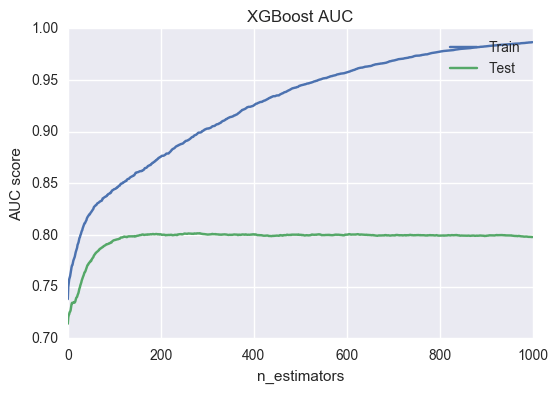

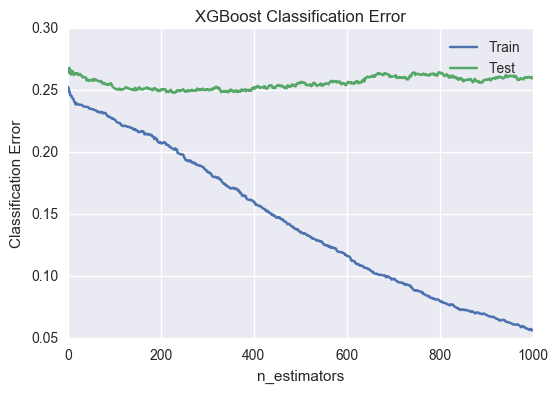

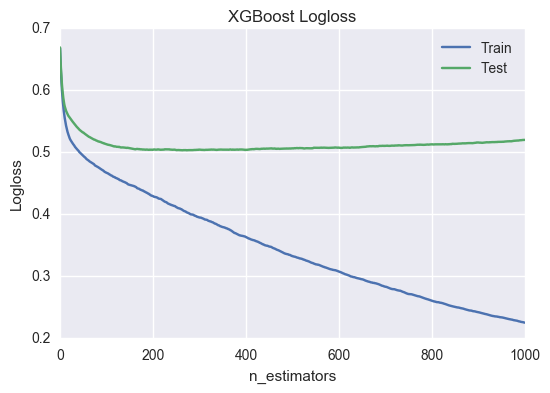

In [56]:
# retrieve performance metrics
results = clf.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
# plot AUC score
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.title('XGBoost AUC')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.xlabel('n_estimators')
plt.title('XGBoost Classification Error')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Logloss')
plt.xlabel('n_estimators')
plt.title('XGBoost Logloss')
plt.show()

In [57]:
clf = xgb.XGBClassifier(n_estimators=1000)
eval_set  = [(train,y_train), (valid,y_valid)]
clf.fit(train, y_train, eval_set=eval_set, 
        eval_metric=["auc"], early_stopping_rounds=50)

[0]	validation_0-auc:0.737821	validation_1-auc:0.713973
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.74943	validation_1-auc:0.719991
[2]	validation_0-auc:0.753493	validation_1-auc:0.722305
[3]	validation_0-auc:0.756862	validation_1-auc:0.72317
[4]	validation_0-auc:0.758615	validation_1-auc:0.725147
[5]	validation_0-auc:0.760102	validation_1-auc:0.725668
[6]	validation_0-auc:0.762657	validation_1-auc:0.726918
[7]	validation_0-auc:0.765533	validation_1-auc:0.73012
[8]	validation_0-auc:0.76844	validation_1-auc:0.732638
[9]	validation_0-auc:0.770408	validation_1-auc:0.734183
[10]	validation_0-auc:0.770771	validation_1-auc:0.734039
[11]	validation_0-auc:0.773053	validation_1-auc:0.734086
[12]	validation_0-auc:0.775141	validation_1-auc:0.73458
[13]	validation_0-auc:0.776379	validation_1-auc:0.734924
[14]	validation_0-auc:0.777844	validation_1-auc:0.73456
[15]

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Best value for n_estimators is therefore : 190

#### Another way to tune xgboost with hyperopt...

In [32]:
def objective_function(x_int):
    objective_function.n_iterations += 1
    n_estimators, max_depth = x_int
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    clf = pip_clf
    scores = cross_val_score(clf, x, y, cv=kfold, scoring='roc_auc')
    print objective_function.n_iterations, \
        ": n_estimators = ", n_estimators, \
        "\tmax_depth = ", max_depth, \
        "accuracy = ", np.mean(scores)
    return 1 - np.mean(scores)

In [33]:
from hyperopt import fmin as hyperopt_fmin
from hyperopt import tpe, hp, STATUS_OK, space_eval

objective_function.n_iterations = 0
best = hyperopt_fmin(objective_function,
                    space=(hp.qloguniform('n_estimators', np.log(10), np.log(1000), 10), 
                           hp.qloguniform('max_depth', np.log(2), np.log(100), 1)),
                    algo=tpe.suggest,
                    max_evals=10)

1 : n_estimators =  164 	max_depth =  39 accuracy =  0.809691051243
2 : n_estimators =  164 	max_depth =  5 accuracy =  0.809691051243
3 : n_estimators =  164 	max_depth =  7 accuracy =  0.809691051243


KeyboardInterrupt: 

In this case I have only tuned n_estimators.  
With time, I could also tune max_depth as it usually impacts performance, and then other tree-based hyperparameters (leaves).  
Then I would lower the learning-rate and increase the number of estimators proportionnally to see to what extent we could improve our CV score.  

### Roc curve
Our xgboost classifier model allows us to plot ROC curves.  
We have:
- True Positive Rate = True Positive / (TP + FN)  
- False Positive Rate = False Positive / (TN + FP)  
  
We plot a Receiver Operating Characteristic (ROC) curve, to illustrate the performance of our binary classifier system as its discrimination threshold (probability) is varied (ROC visualizes performance for all classification thresholds).  
We see that our xgboost classifier does a good job separating our two imbalanced classes.

In [20]:
from sklearn.model_selection import train_test_split
train, valid, y_train, y_valid = train_test_split(x,y)

CPU times: user 54.9 s, sys: 1.22 s, total: 56.1 s
Wall time: 23.3 s


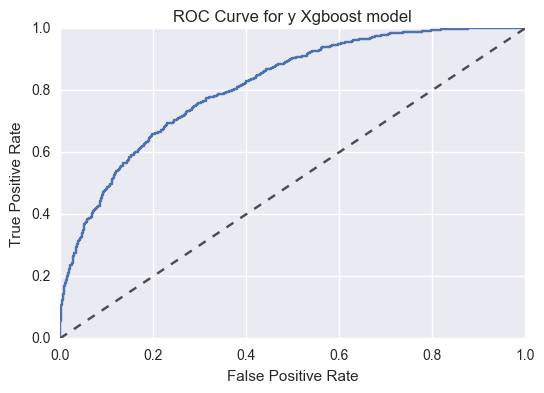

In [23]:
%%time
xgbclf.fit(train, y_train)
probas_y = xgbclf.predict_proba(valid)
fig, ax = plt.subplots()
plt.title('ROC Curve for y Xgboost model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(roc_curve(y_valid, probas_y[:,1])[0], roc_curve(y_valid, probas_y[:,1])[1])
# We also plot y = x
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

## 4. Prediction

### Make prediction

In [58]:
pip_clf = make_pipeline(
            Imputer(strategy='mean'),
            xgb.XGBClassifier(max_depth=50,
#                                learning_rate=0.05,
                                learning_rate=0.1,
                                n_estimators=190, 
                                silent=1,
                                objective='binary:logistic', 
                                nthread=3, 
                                gamma=0.001,
                                min_child_weight=1, 
                                max_delta_step=0,
                                subsample=1, 
                                colsample_bytree=1, 
                                colsample_bylevel=1, 
                                reg_alpha=0, 
                                reg_lambda=1, 
                                scale_pos_weight=1, 
                                base_score=0.508, 
                                seed=0, 
                                missing=None)
                        )

In [ ]:
%%time
estimator = pip_clf
results = cross_val_score(estimator, x, y, cv=kfold, n_jobs=1, scoring="roc_auc")
print("Results: %.2f%% (%.2f%%) on %d stratkfolds" % (results.mean()*100, results.std()*100, kfold.get_n_splits()))

In [39]:
%%time
pip_clf.fit(x,y)
y_pred = pd.DataFrame()
y_pred['ID'] = data_test['ID']
y_pred['Target'] = pip_clf.predict_proba((data_test.drop(["ID"],axis=1)))[:,1]

CPU times: user 1min 41s, sys: 2.14 s, total: 1min 43s
Wall time: 45.5 s


### Print prediction

In [40]:
y_pred.to_csv('submissions/xgb_lr_conso2.csv', index=False)

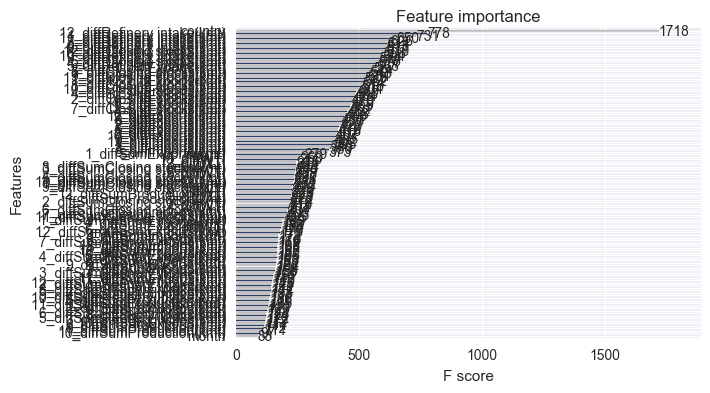

In [145]:
xgb.plot_importance(xgbclf);